# The Landlab GravelRiverTransporter Component

*G.E. Tucker, CIRES and Department of Geological Sciences, University of Colorado Boulder*

This notebook describes the `GravelRiverTransporter` component and its underlying theory, and provides some simple examples of usage.


## Overview

`GravelRiverTransporter` is a Landlab component for modeling landscape evolution in the context of a network of gravel-bed alluvial channels. The component is meant to operate on a 2d grid in conjunction with a single-direction flow routing scheme, such that each grid node drains to one and only one of its neighbors. Channels are assumed to be sub-grid-scale features with a bankfull channel width that adjusts according to the local discharge, slope, and grain diameter. The approach follows that of Wickert & Schildgen (2019), but with two additions:

1. Because the channel network is calculated from, and embedded within, a topographic field represented as a 2d grid, conservation of mass is calculated on the basis of individual grid cells rather than using a prescribed valley width.

2. The theory implemented by the component includes the progressive loss of gravel load due to abrasion; the lost material is assumed to become part of the suspended and/or wash load, which is not explicitly tracked.

The theory that channels with gravel bed and bank materials tend to adjust their shear stress ratio dates back to Parker (1978), and a variety of studies have supported the idea for gravel rivers. Phillips and Jerolmack (2016) argued that the concept may also be applicable to some "bedrock" rivers as well (the question depends somewhat on the definition of "bedrock river", but presumably would apply to a river that is capable of eroding into bedrock but that also has at least one self-formed bank made of alluvial material, so that erosion or deposition of bank material alters the hydraulic geometry).

## Theory

### Channel-width adjustment

We treat only the coarse, bed-load fraction. We assume channel width adjusts so as to ensure that bankfull shear stress is slightly larger (by a fraction $\epsilon$) than critical shear stress for the median sediment diameter. Wickert & Schildgen (2019) show that when this is the case, the channel tends to adjust such that its bankfull width depends on bankfull discharge, $Q$, channel gradient, $S$, and the median diameter of sediment on the bed, $D$, as follows: 

$$b = k_b \frac{QS^{7/6}}{D^{3/2}}$$

where $k_b$ is a factor given by:

$$k_b = 0.17 g^{-1/2} \left[ \left(\frac{\rho_s-\rho}{\rho}\right)(1+\epsilon )\tau_c^*\right]^{-5/3}$$

where $g$ is gravitational acceleration, $\rho_s$ is sediment grain density, $\rho$ is water density, $\epsilon$ is the ratio of bankfull to critical shear stress, and $\tau_c^*$ is the critical Shields stress (i.e., dimensionless critical shear stress). Using $g=9.8$ m/s$^2$, $\rho_s=2,650$ kg/m$^3$ (quartz), $\rho=1,000$ kg/m$^3$, $\epsilon=0.2$, and $\tau_c^*=0.0495$ (from Wong & Parker, 2006), the value of $k_b$ is approximately 2.61 s/m$^{1/2}$ (as calculated below).

In [1]:
g = 9.8  # gravitational acceleration, m/s2
rhos = 2650.0  # sediment density, kg/m3
rho = 1000.0  # water density, kg/m3
eps = 0.2  # shear stress ratio
taustarc = 0.0495  # critical Shields stress (here from Wong & Parker (2006))

kb = 0.17 * g ** (-0.5) * (((rhos - rho) / rho) * (1 + eps) * taustarc) ** (-5.0 / 3.0)
print("kb =", kb, "seconds per square-root meter")
print("kb =", kb / (3600 * 24 * 365.25), "years per square-root meter")

kb = 2.6064650240601455 seconds per square-root meter
kb = 8.259389256661297e-08 years per square-root meter


For example, the width of a channel with 1 cm diameter sediment on the bed, a 1% gradient, and a bankfull discharge with 1 cms discharge would be:

In [2]:
D = 0.01  # grain diameter, m
Q = 1.0  # bankfull discharge, m3/s
S = 0.01  # slope gradient, m/m
print("b = " + str(kb * Q * S ** (7.0 / 6.0) / D**1.5), "meters")

b = 12.098138950879829 meters


Note that one aspect of the above width theory that may limit its applicability is the prediction that width should *increase* when slope increases. To appreciate where this comes from, recall that boundary shear stress in a relatively wide channel is proportional to the depth-slope product (i.e., $\tau \approx \rho g H S$, where $H$ is depth and $S$ is slope). All else equal, for a fixed shear stress, a steeper channel should be shallower and vice versa. For a given discharge, a shallower channel must either be wider or have faster flow, or both. So the prediction is logically and mathematically consistent. However, it neglects potential variations in roughness, and in particular the possibility that steeper channels might become rougher as the flow increases toward criticality (as suggested by Grant, 1997). The theory outlined here does not attempt to account for this effect, but users of the component should be aware of this limitation. In addition, the underlying treatment of shear stress as proportional to depth times slope is not appropriate for channels with a relatively small width-depth ratio. The component does not include any checks on this, so the user should be alert to unrealistic behavior when the calculated channel width is rather narrow.

### Gravel transport rate

We follow Wickert and Schildgen (2019) in using the Meyer-Peter and Müller (1948) equation for bed-load transport, as modified by Wong and Parker (2006). When combined with the width-closure equation above, the predicted gravel transport rate is:

$$Q_s = k_Q I Q S^{7/6}$$

where $k_Q$ is a dimensionless transport efficiency factor equal to $\approx 0.041$. The variable $I$ is an efficiency factor, defined as the fraction of time that bankfull discharge occurs. In other words, one of the simplifications of the model is that the channel has two states: for a small fraction of the year, flow is equal to bankfull; for the rest of the time, the flow is too low to move any sediment.

To get a sense for what the transport law implies about rates, consider a case in which $Q = 1$ cms, $S = 0.01$, and bankfull flow occurs for 1% of the year:

In [3]:
Qs = 0.041 * 0.01 * 1 * (0.01) ** (7.0 / 6.0)
print("Qs", Qs, "cms")
print("Qs", Qs * 3600 * 24 * 365.25, "cubic meters per year")

Qs 1.903051421781239e-06 cms
Qs 60.05573554800362 cubic meters per year


This implies that 1 cms on a slope of 0.01 would carry about $2 \times 10^{-6}$ cms of sediment, or about 60 cubic meters in a given year.

### Gravel abrasion

The component uses a Sternberg-like method to calculate the downstream loss of mass to abrasion. The abrasion model is inspired by Attal & Lave (2006, 2009). We assume that the rate of loss of gravel mass to finer material per unit transport distance, $A$, is proportional to the gravel transport rate, $Q_s$:

$$A = \beta Q_s$$

where $\beta$ is an abrasion coefficient with units of inverse length.

To appreciate the implication of this treatment, consider a reach of channel with an incoming gravel load $Q_0$ at the head of the reach, and no inputs along the reach itself. The rate of change of gravel load with respect to downstream distance, $x$, is:

$$\frac{dQ_s}{dx} = -\beta Q_s$$

Integrating downstream from the head of the reach $x=0$, where $Q_s=Q_0$, 

$$Q_s = Q_0 e^{-\beta x}$$

In other words, one obtains a Sternberg-like profile, except here expressed in terms of remaining gravel load rather than median size.

## Setting up a gravel river model

In the code below, we create a class that turns the `GravelRiverTransporter` component into a stand-alone model. This will make it simpler to set up and run examples.

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from landlab import create_grid, imshow_grid
from landlab.components import FlowAccumulator, GravelRiverTransporter
from landlab.plot.drainage_plot import drainage_plot

mpl.rcParams["figure.dpi"] = 300

In [5]:
class GravelRiverNetworkModel:
    """Model of gravel river transport & evolution on a
    flow-network grid.

    Parameters
    ----------
    grid_params : dict
        Dictionary of grid parameters (for format see create_grid)
    flow_params : dict
        Dictionary with FlowAccumulator parameters
    fluvial_params : dict, default empty
        Dictionary with GravelRiverTransporter parameters
    initial_noise_amplitude : float, default 0
        Amplitude of random noise on initial topography
    uplift_rate : float, default 0.0001
        Applied uplift (baselevel) rate in m/y
    run_duration : float, default 1.0e4
        Duration of run in years
    dt : float, default 100
        Time-step duration, years
    grid_setup_fn : function, default None
        Handle to user-defined function to set up the grid
    grid_setup_params : dict, default empty
        Dict with any parameters to be passed to the above function
    """

    _DEFAULT_GRID_PARAMS = {
        "RasterModelGrid": {
            "shape": (4, 5),
            "xy_spacing": 1000.0,
            "fields": {
                "node": {"topographic__elevation": {"constant": [{"value": 0.0}]}}
            },
        }
    }

    _DEFAULT_FLOW_PARAMS = {"flow_director": "FlowDirectorD8"}

    _DEFAULT_FLUVIAL_PARAMS = {}

    def __init__(
        self,
        grid_params=_DEFAULT_GRID_PARAMS,
        flow_params=_DEFAULT_FLOW_PARAMS,
        fluvial_params=_DEFAULT_FLUVIAL_PARAMS,
        initial_noise_amplitude=0.0,
        uplift_rate=0.0001,
        run_duration=1.0e4,
        dt=100.0,
        grid_setup_fn=None,
        grid_setup_params={},
    ):
        """Initialize GravelRiverNetworkModel."""

        self.grid = create_grid({**self._DEFAULT_GRID_PARAMS, **grid_params})
        self.elev = self.grid.at_node["topographic__elevation"]
        if grid_setup_fn is not None:
            grid_setup_fn(self.grid, **grid_setup_params)
        if initial_noise_amplitude > 0.0:
            self.elev[self.grid.core_nodes] += initial_noise_amplitude * np.random.rand(
                self.grid.number_of_core_nodes
            )
        self.flow_handler = FlowAccumulator(
            self.grid, **{**self._DEFAULT_FLOW_PARAMS, **flow_params}
        )
        self.transporter = GravelRiverTransporter(
            self.grid, **{**self._DEFAULT_FLUVIAL_PARAMS, **fluvial_params}
        )
        self.uplift_rate = uplift_rate
        self.time_remaining = run_duration
        self.dt = dt

    def run(self):
        """Run model from start to finish."""
        while self.time_remaining > 0.0:
            dt = min(self.dt, self.time_remaining)
            self.update(dt)
            self.time_remaining -= dt

    def update(self, dt):
        """Update for one time step of duration dt."""
        self.elev[self.grid.core_nodes] += self.uplift_rate * dt
        self.flow_handler.run_one_step()
        self.transporter.run_one_step(dt)

## Example: 1d longitudinal profile

This example compares a 1d profile version of the model with the steady analytical solution. The analytical solution is presented in two parts: the special case of no abrasion ($\beta = 0$), and the more general case with abrasion ($\beta > 0$).

### Special case of no abrasion

#### Downstream gravel flux

Consider a valley of width $\Delta y$ with no tributaries or other inputs of water or sediment. Down-valley distance is $x$. Let the bankfull runoff rate be $r$ (in depth of runoff per time, e.g., meters per year), and assume the discharge is proportional to drainage area, $A$, such that the bankfull discharge increases linearly with down-valley distance:

$$Q = r A = r x \Delta y$$

Let the steady erosion (channel lowering) rate be $E$. When the erosion rate is steady, the rate of increase in volumetric gravel flux with respect to down-valley distance depends on two effects: the addition of new gravel through lowering of the valley, and the loss of gravel to finer material through abrasion. We can express this as:

$$\frac{dQ_s}{dx} = \psi (1-\phi_s) E\Delta y - \beta Q_s$$

Here $\phi_s$ is the porosity of the substrate into which the valley lowers through time, and $\psi$ is the fraction of entrained material that is of gravel size (note that the latter parameter is assumed to be unity in the GravelRiverTransporter component).

For the special case of $\beta = 0$ (no abrasion), the integral is simply:

$$\boxed{Q_s = \psi (1-\phi_s) E\Delta y x}$$

In other words, with no abrasion, the gravel flux increases linearly down-valley.

#### Profile shape

To solve for the profile shape, we set the gravel flux equal to the transport rate and solve for slope gradient. For the special case of no abrasion ($\beta = 0$),

$$k_Q I Q S^{7/6} = \psi (1-\phi_s) E \Delta y x$$

Rearranging, and substituting the relationship between discharge and distance,

$$\boxed{S = \left(\frac{\psi (1-\phi_s) E}{k_Q I r}\right)^{6/7}}$$

Note that slope gradient does not depend on position along the valley! In other words, when the rate of water and sediment addition down-valley are both linear, the two effects balance and gradient remains constant. All else equal, the profile will be steeper with more sediment (higher $E$, $\psi$) and gentler with more transport potential (more frequent flow, more runoff, or a higher transport coefficient).

#### Numerical test

To create an effectively one-dimensional domain, we run a model with three rows of nodes, two of which are closed boundaries and one of which is the model domain. The code below can be summarized as:

1. Define a grid setup function to configure a 1d domain with an initial down-valley slope.
2. Set parameter values.
3. Create dictionaries for the grid, flow, and fluvial parameters.
4. Instantiate and initialize the model object.
5. Run it.
6. Plot and compare with analytical solutions.


In [6]:
# Define grid setup function for 3 rows with open boundary at right side


def channel_profile_setup(grid, init_slope):
    """Set boundary nodes to CLOSED except the right side, which is the profile
    outlet; give"""
    grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED
    grid.status_at_node[grid.nodes_at_right_edge] = grid.BC_NODE_IS_FIXED_VALUE
    grid.at_node["topographic__elevation"][grid.core_nodes] = init_slope * (
        np.amax(grid.x_of_node) - grid.x_of_node[grid.core_nodes]
    )

In [7]:
# Parameters
nrows = 3
ncols = 17
dx = 1000.0  # grid spacing, m
bf_runoff_rate = 10.0  # bankfull runoff rate, m/y
imfac = 0.01  # intermittency factor, -
xport_coef = 0.041  # transport coefficient, -
abr_coef = 0.0  # abrasion coefficient, 1/m
porosity = 0.35  # sediment porosity, -
uplift_rate = 0.0001  # uplift (i.e., baselevel) rate, m/y

In [8]:
# Group parameters into dicts for grid, flow, and fluvial
profile_grid_params = {
    "RasterModelGrid": {
        "shape": (nrows, ncols),
        "xy_spacing": dx,
        "fields": {"node": {"topographic__elevation": {"constant": [{"value": 0.0}]}}},
    }
}

flow_params = {
    "flow_director": "FlowDirectorD8",
    "runoff_rate": bf_runoff_rate,
}

fluvial_params = {
    "intermittency_factor": imfac,
    "transport_coefficient": xport_coef,
    "abrasion_coefficient": abr_coef,
    "sediment_porosity": porosity,
}

In [9]:
# Instantiate model
model = GravelRiverNetworkModel(
    profile_grid_params,
    flow_params,
    fluvial_params,
    uplift_rate=uplift_rate,
    run_duration=1.8e7,
    dt=3000.0,
    grid_setup_fn=channel_profile_setup,
    grid_setup_params={"init_slope": 0.0001},
)

In [10]:
# Run model
model.run()

In [11]:
# Set up for plotting 1D profiles
midrow = np.arange(ncols + 1, 2 * ncols, dtype=int)
profile_x = model.grid.x_of_node[midrow]

Predicted gravel flux at outlet: 975.0 m3/y
Computed gravel flux: 974.027791716 m3/y


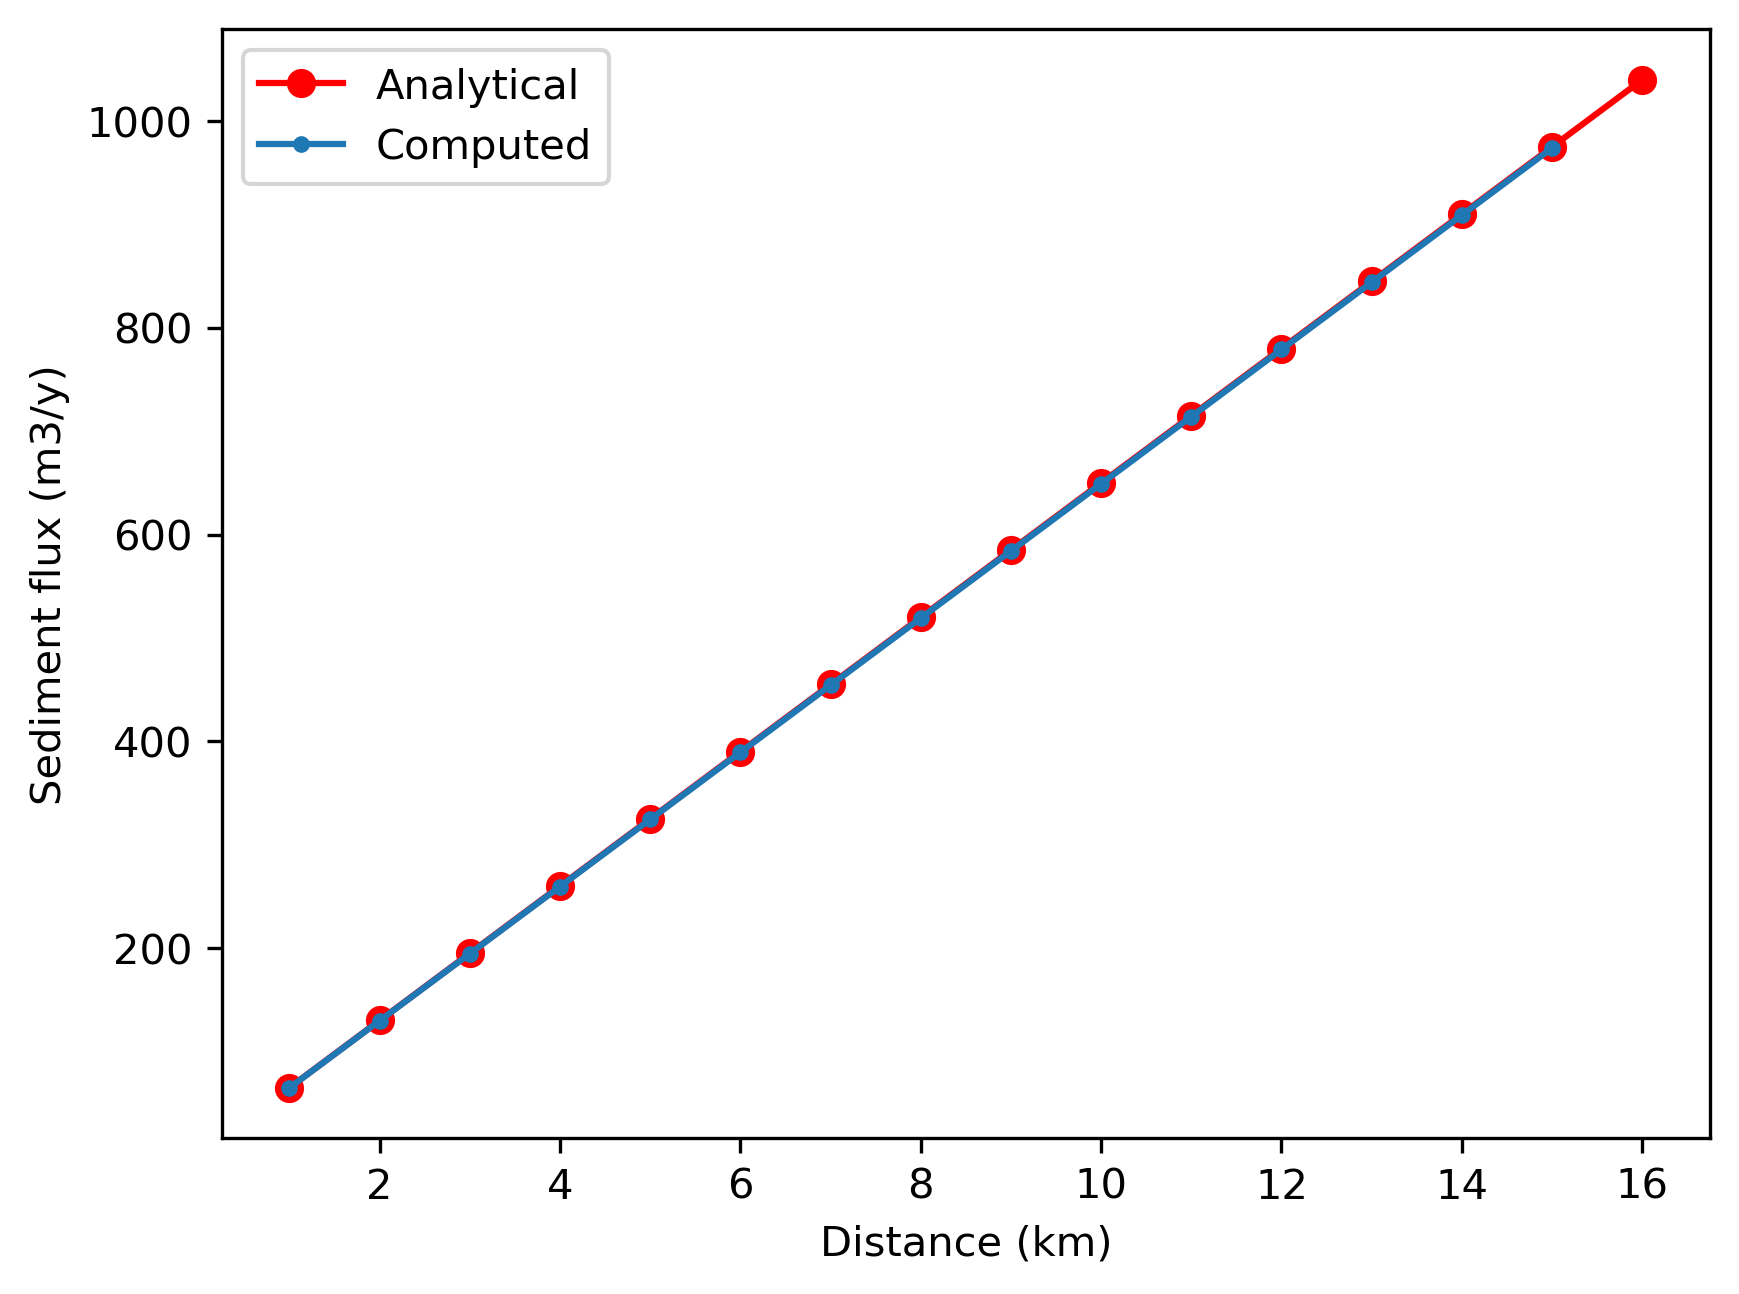

In [12]:
# Calculate analytical solution for gravel flux
Qspred = uplift_rate * (1 - porosity) * dx * profile_x

# Plot
plt.plot(profile_x / 1000.0, Qspred, "ro-")
plt.plot(
    profile_x[:-1] / 1000.0,
    model.grid.at_node["bedload_sediment__volume_outflux"][midrow[:-1]],
    ".-",
)
plt.xlabel("Distance (km)")
plt.ylabel("Sediment flux (m3/y)")
plt.legend(["Analytical", "Computed"])

# Report
print("Predicted gravel flux at outlet:", Qspred[-2], "m3/y")
print(
    "Computed gravel flux:",
    model.grid.at_node["bedload_sediment__volume_outflux"][midrow[-2]],
    "m3/y",
)

Predicted gradient: 0.02865852650156155
Computed gradient at outlet: 0.0286340306404


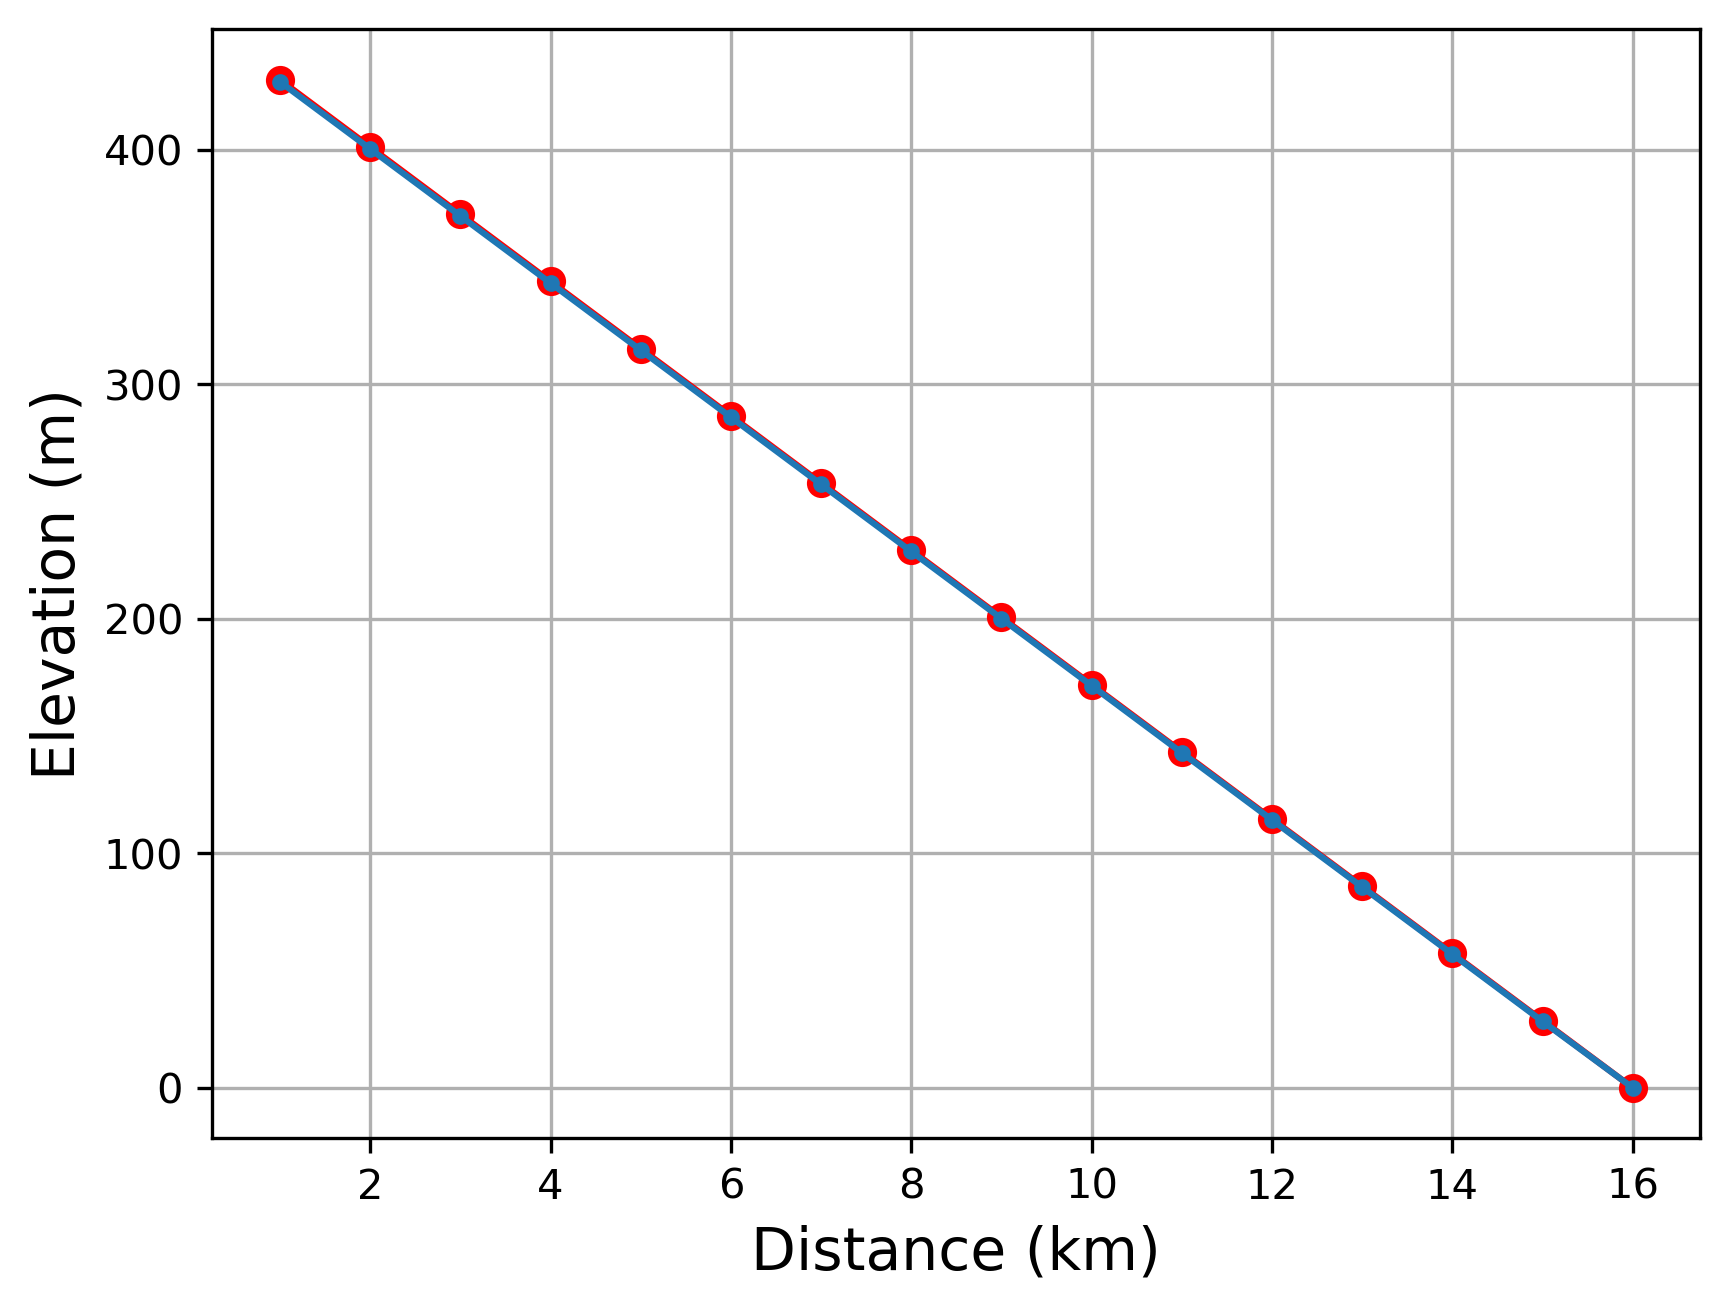

In [13]:
# Calculate analytical solution for gradient
Spred = (
    1.0 * (1.0 - porosity) * uplift_rate / (xport_coef * imfac * bf_runoff_rate)
) ** (6.0 / 7.0)

# Analytical solution for height
Zpred = Spred * (np.amax(model.grid.x_of_node) - model.grid.x_of_node[midrow])

# Plot
plt.plot(model.grid.x_of_node[midrow] / 1000.0, Zpred, "ro-")
plt.plot(model.grid.x_of_node[midrow] / 1000.0, model.elev[midrow], ".-")
plt.xlabel("Distance (km)", fontsize=14)
plt.ylabel("Elevation (m)", fontsize=14)
plt.grid(True)

# Report
print("Predicted gradient:", Spred)
print(
    "Computed gradient at outlet:",
    np.mean(model.grid.at_node["topographic__steepest_slope"][midrow[-2]]),
)

The above example demonstrates that the model can reproduce the expected equilibrium without abrasion, and that it takes a long time (about 18 million years using the given parameters) to get there. The example also illustrates the uniform gradient predicted by the case without sediment abrasion (which is at odds with the common observation that channel longitudinal profiles tend to be concave-upward).

We can also examine the implied channel width. The width depends median bed grain diameter, so we will set this to 10 cm for illustrative purposes:

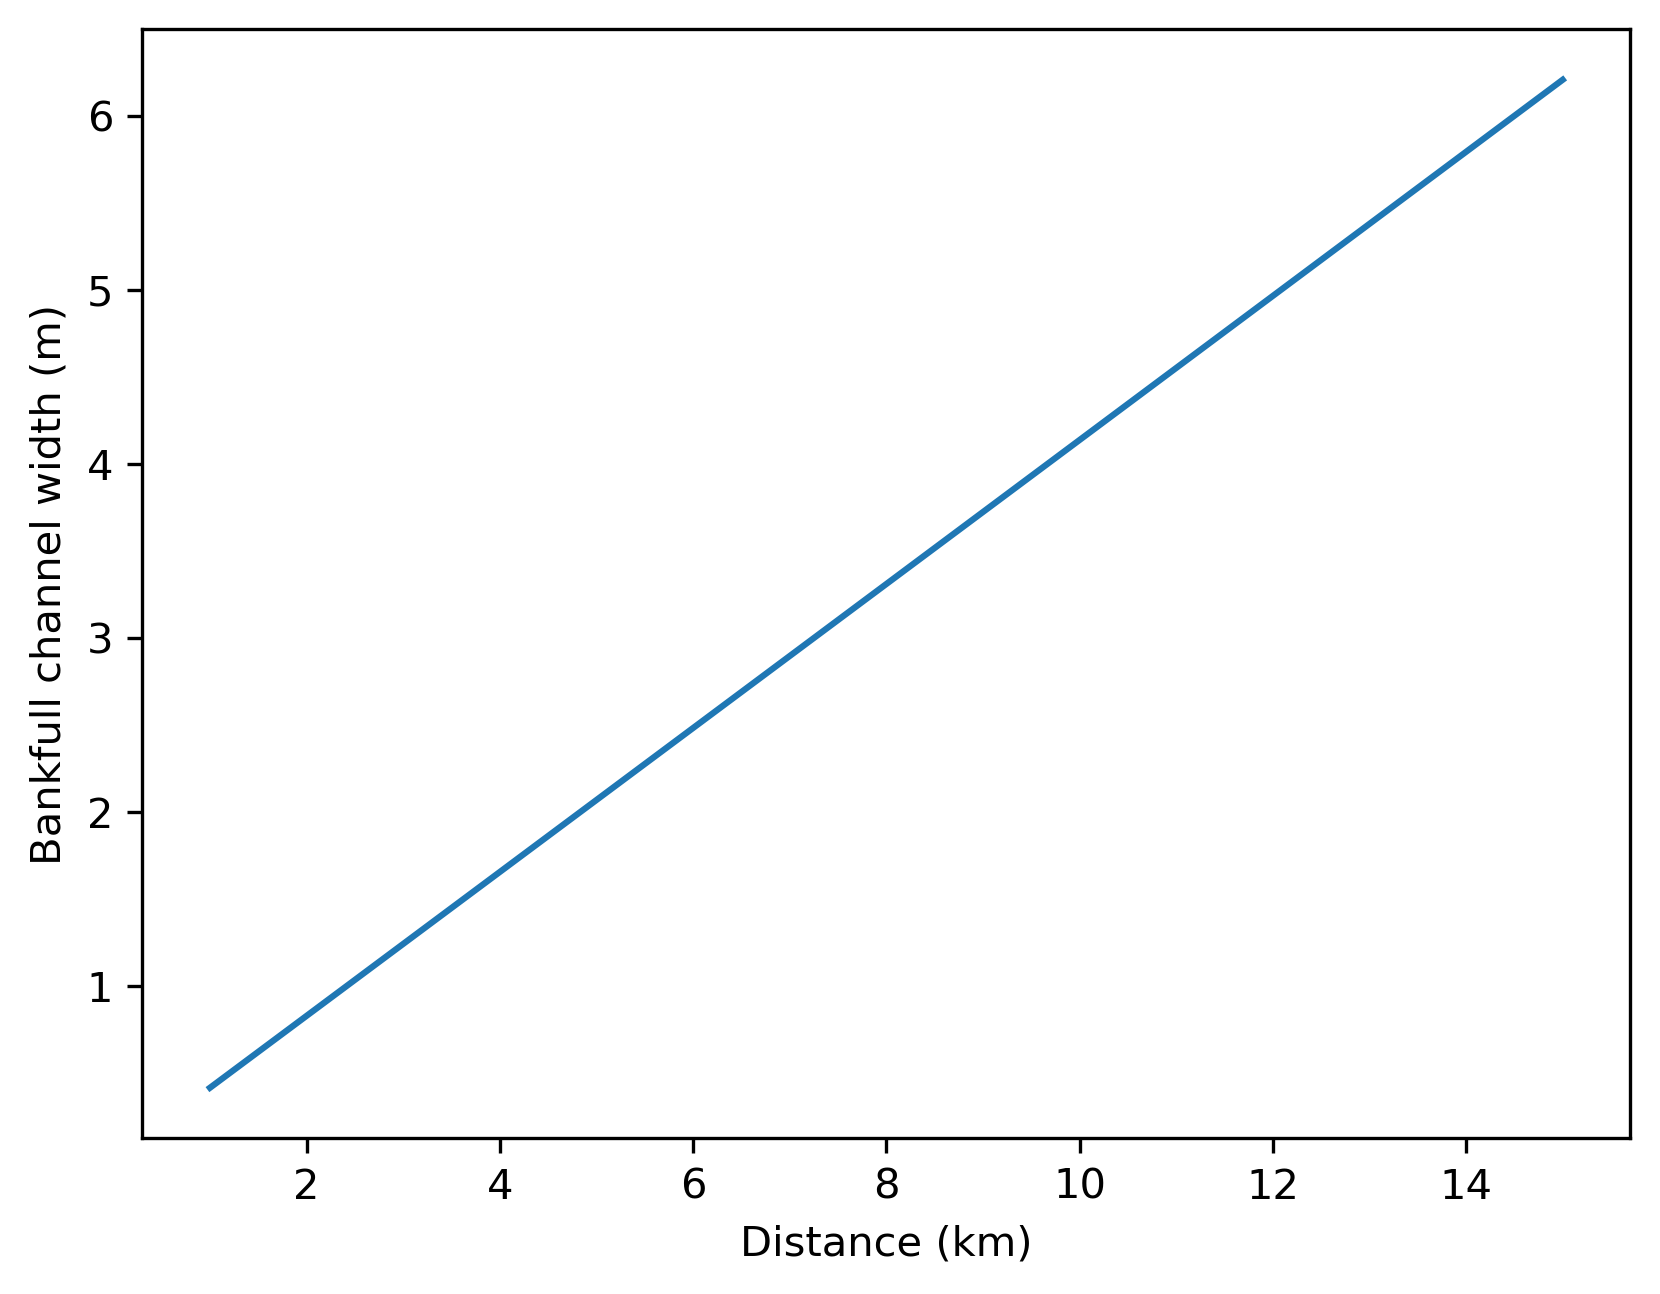

In [14]:
w = model.transporter.calc_implied_width(grain_diameter=0.1)
plt.plot(profile_x[:-1] / 1000.0, w[midrow[:-1]])
plt.xlabel("Distance (km)")
_ = plt.ylabel("Bankfull channel width (m)")

Without abrasion (and with a linear relation between bankfull discharge and drainage area), we obtain the odd result that width increases linearly with bankfull discharge, rather than approximately square-root relation that is commonly observed. This in fact is perfectly consistent: since the channel maintains a fixed shear-stress ratio, the only way for the channel to accommodate a downstream-increasing sediment load is by widening, and because the sediment load grows linearly downstream, so too must the channel width.

Neither the linear profile nor the linear width increase are particularly realistic, at least when compared with most erosional river profiles. The next example looks at the role of gravel abrasion, and considers the extent to which it can produce more realistic profile morphology.


### General case with abrasion

#### Downstream gravel flux

Recall that the downstreamrate of change in gravel flux is 

$$\frac{dQ_s}{dx} = \psi (1-\phi_s) E\Delta y - \beta Q_s$$

To integrate this for the general case of $\beta > 0$, we can use the method of substitution. Let $\alpha = \psi (1-\phi_s) E \Delta y$, and $w = \alpha - \beta Q_s$. Then $dw = -\beta dQ_s$, so that $dQ_s = -(1/\beta) dw$. 

At $x=0$, the head of the reach, $Q_s=0$. Therefore, when $x=0$, $w=\alpha$.

Substituting these,

$$-\frac{1}{\beta} \frac{dw}{dx} = w$$

$$\frac{1}{w}dw = -\beta dx$$

Integrating from $w = \alpha$ to $w$ and from $x = 0$ to $x$,

$$\ln \frac{w}{\alpha} = -\beta x$$

$$\frac{w}{\alpha} = e^{-\beta x}$$

$$\alpha - \beta Q_s = \alpha e^{-\beta x}$$

$$\beta Q_s = \alpha (1 - e^{-\beta x})$$

$$\boxed{Q_s = \frac{\psi (1-\phi_s) E \Delta y}{\beta} (1 - e^{-\beta x})}$$

The implication is that the sediment flux is a saturating exponential that asymptotes to an equilibrium value 

$$Q_s^\text{eq} = \frac{\psi (1-\phi_s) E \Delta y}{\beta}$$

which represents a balance between addition of gravel-size sediment through erosional lowering, and loss of gravel-size sediment to finer material through abrasion. The equilibrium flux is larger when the erosion rate is faster, the valley is wider, the eroded material produces a higher gravel fraction, or the eroded material is less porous. The flux is smaller when the abrasion rate is higher.



#### Profile shape

Setting transport rate and gravel supply equal,

$$k_Q I Q S^{7/6} = \frac{\psi (1-\phi_s) E \Delta y}{\beta} (1 - e^{-\beta x})$$

Solving for gradient,

$$S = \left( \frac{\psi (1-\phi_s) E \Delta y}{\beta k_Q I Q }(1 - e^{-\beta x})\right)^{6/7}$$

Substituting the discharge-distance relation,

$$\boxed{S = \left( \frac{\psi (1-\phi_s) E}{\beta k_Q I r x}(1 - e^{-\beta x})\right)^{6/7}}$$

We can use these solutions to test the model, as in the runs that follow.

In [15]:
# Parameters
abr_coef = 1.0 / 2000.0  # abrasion coefficient, 1/m
run_duration = 1.2e7  # duration of run, years
dt = 3000.0  # time-step duration, years
init_slope = 0.0001  # initial valley gradient, m/m

In [16]:
profile_grid_params = {
    "RasterModelGrid": {
        "shape": (nrows, ncols),
        "xy_spacing": dx,
        "fields": {"node": {"topographic__elevation": {"constant": [{"value": 0.0}]}}},
    }
}

flow_params = {
    "flow_director": "FlowDirectorD8",
    "runoff_rate": bf_runoff_rate,
}

fluvial_params = {
    "intermittency_factor": imfac,
    "transport_coefficient": xport_coef,
    "abrasion_coefficient": abr_coef,
    "sediment_porosity": porosity,
}

In [17]:
model = GravelRiverNetworkModel(
    profile_grid_params,
    flow_params,
    fluvial_params,
    uplift_rate=uplift_rate,
    run_duration=run_duration,
    dt=dt,
    grid_setup_fn=channel_profile_setup,
    grid_setup_params={"init_slope": init_slope},
)

In [18]:
model.run()

Predicted gravel flux at outlet: 129.928099032 m3/y
Computed gravel flux at outlet: 129.93887595 m3/y


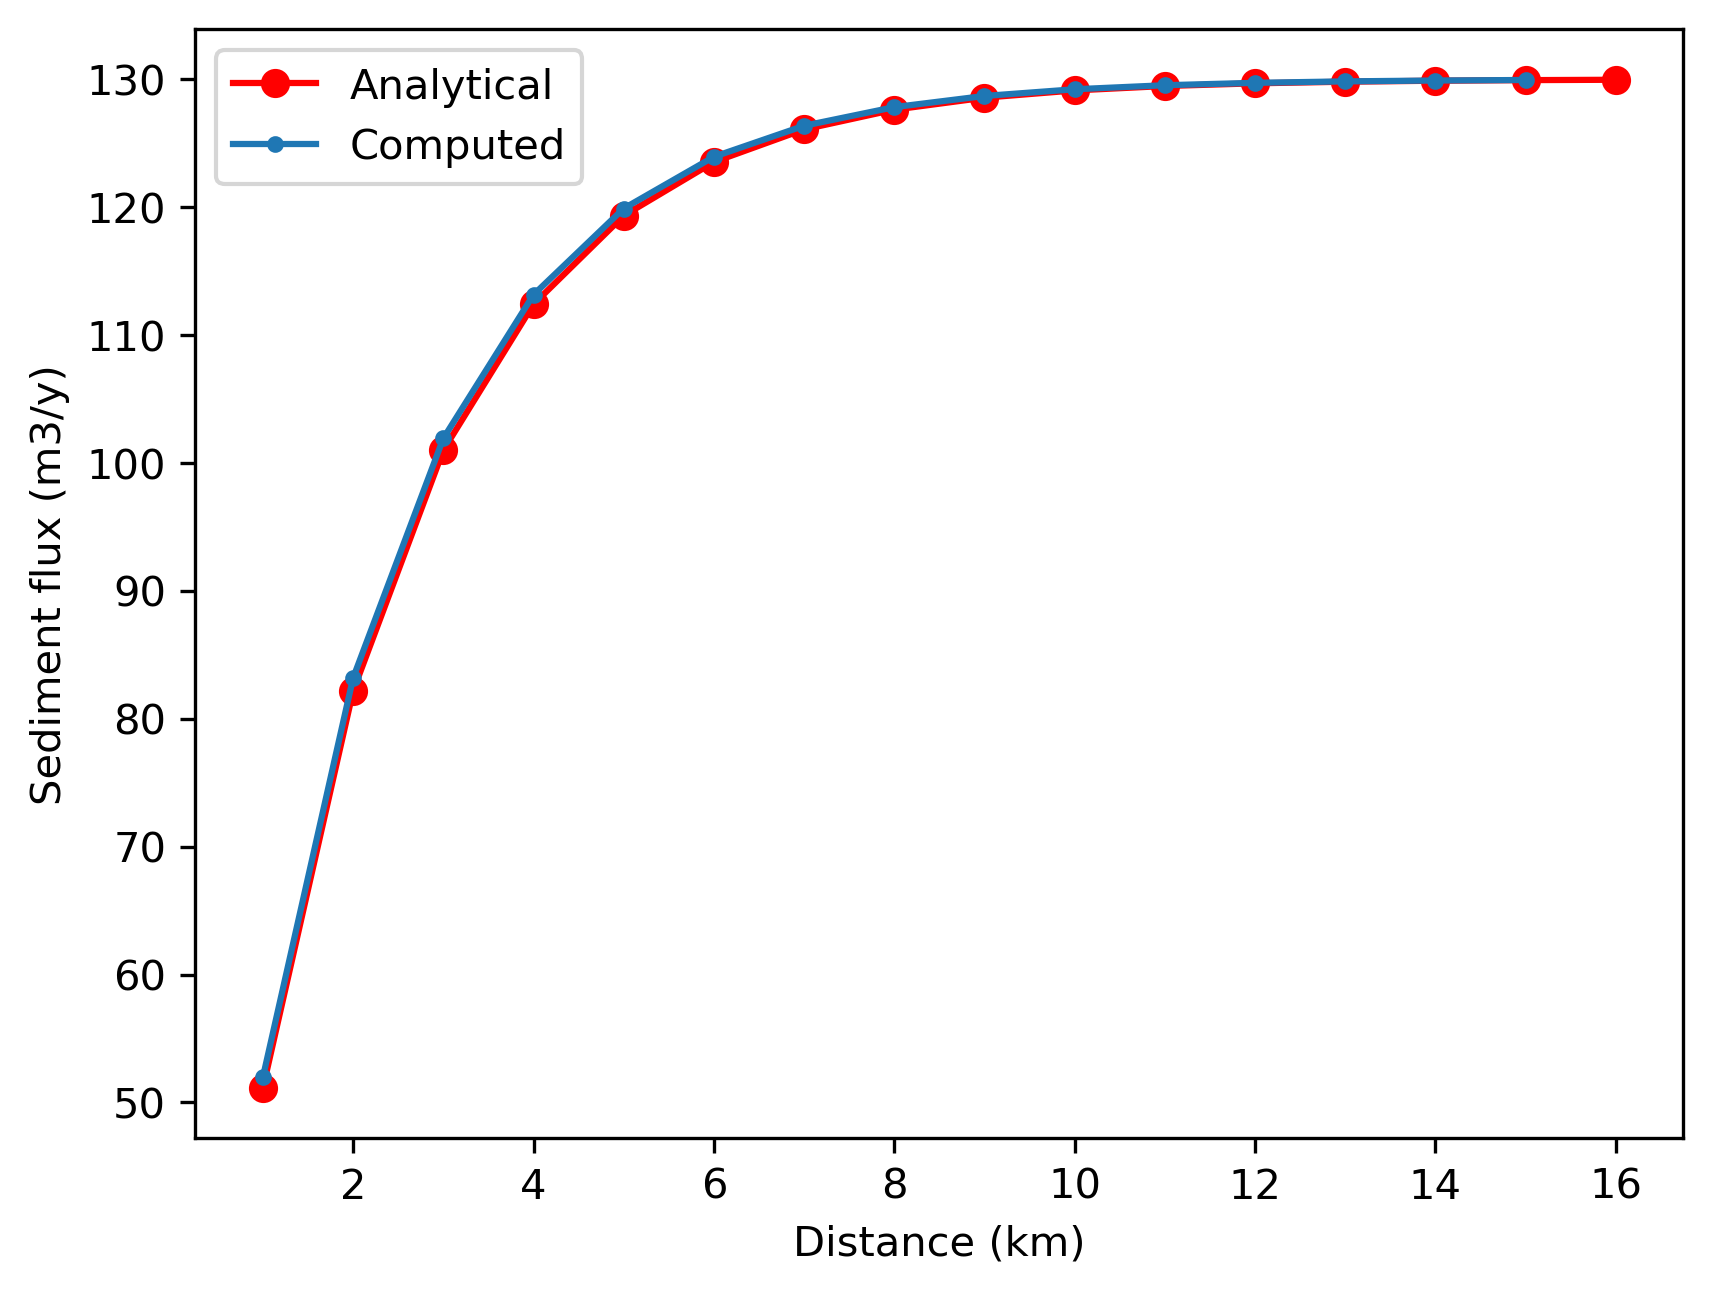

In [19]:
# Calculate analytical solution for gravel flux
Qseqb = (1.0 - porosity) * uplift_rate * dx / abr_coef
Qspred = Qseqb * (1.0 - np.exp(-abr_coef * profile_x))

# Plot
plt.plot(profile_x / 1000.0, Qspred, "ro-")
plt.plot(
    profile_x[:-1] / 1000.0,
    model.grid.at_node["bedload_sediment__volume_outflux"][midrow[:-1]],
    ".-",
)
plt.xlabel("Distance (km)")
plt.ylabel("Sediment flux (m3/y)")
plt.legend(["Analytical", "Computed"])

# Report
print("Predicted gravel flux at outlet:", Qspred[-2], "m3/y")
print(
    "Computed gravel flux at outlet:",
    model.grid.at_node["bedload_sediment__volume_outflux"][midrow[-2]],
    "m3/y",
)

The numerical model captures the downstream asymptotic approach to uniform gravel flux. How does it do with the valley gradient? Let's check this next:

Predicted gradient at outlet: 0.00509325478243
Computed gradient at outlet: 0.00509361688996


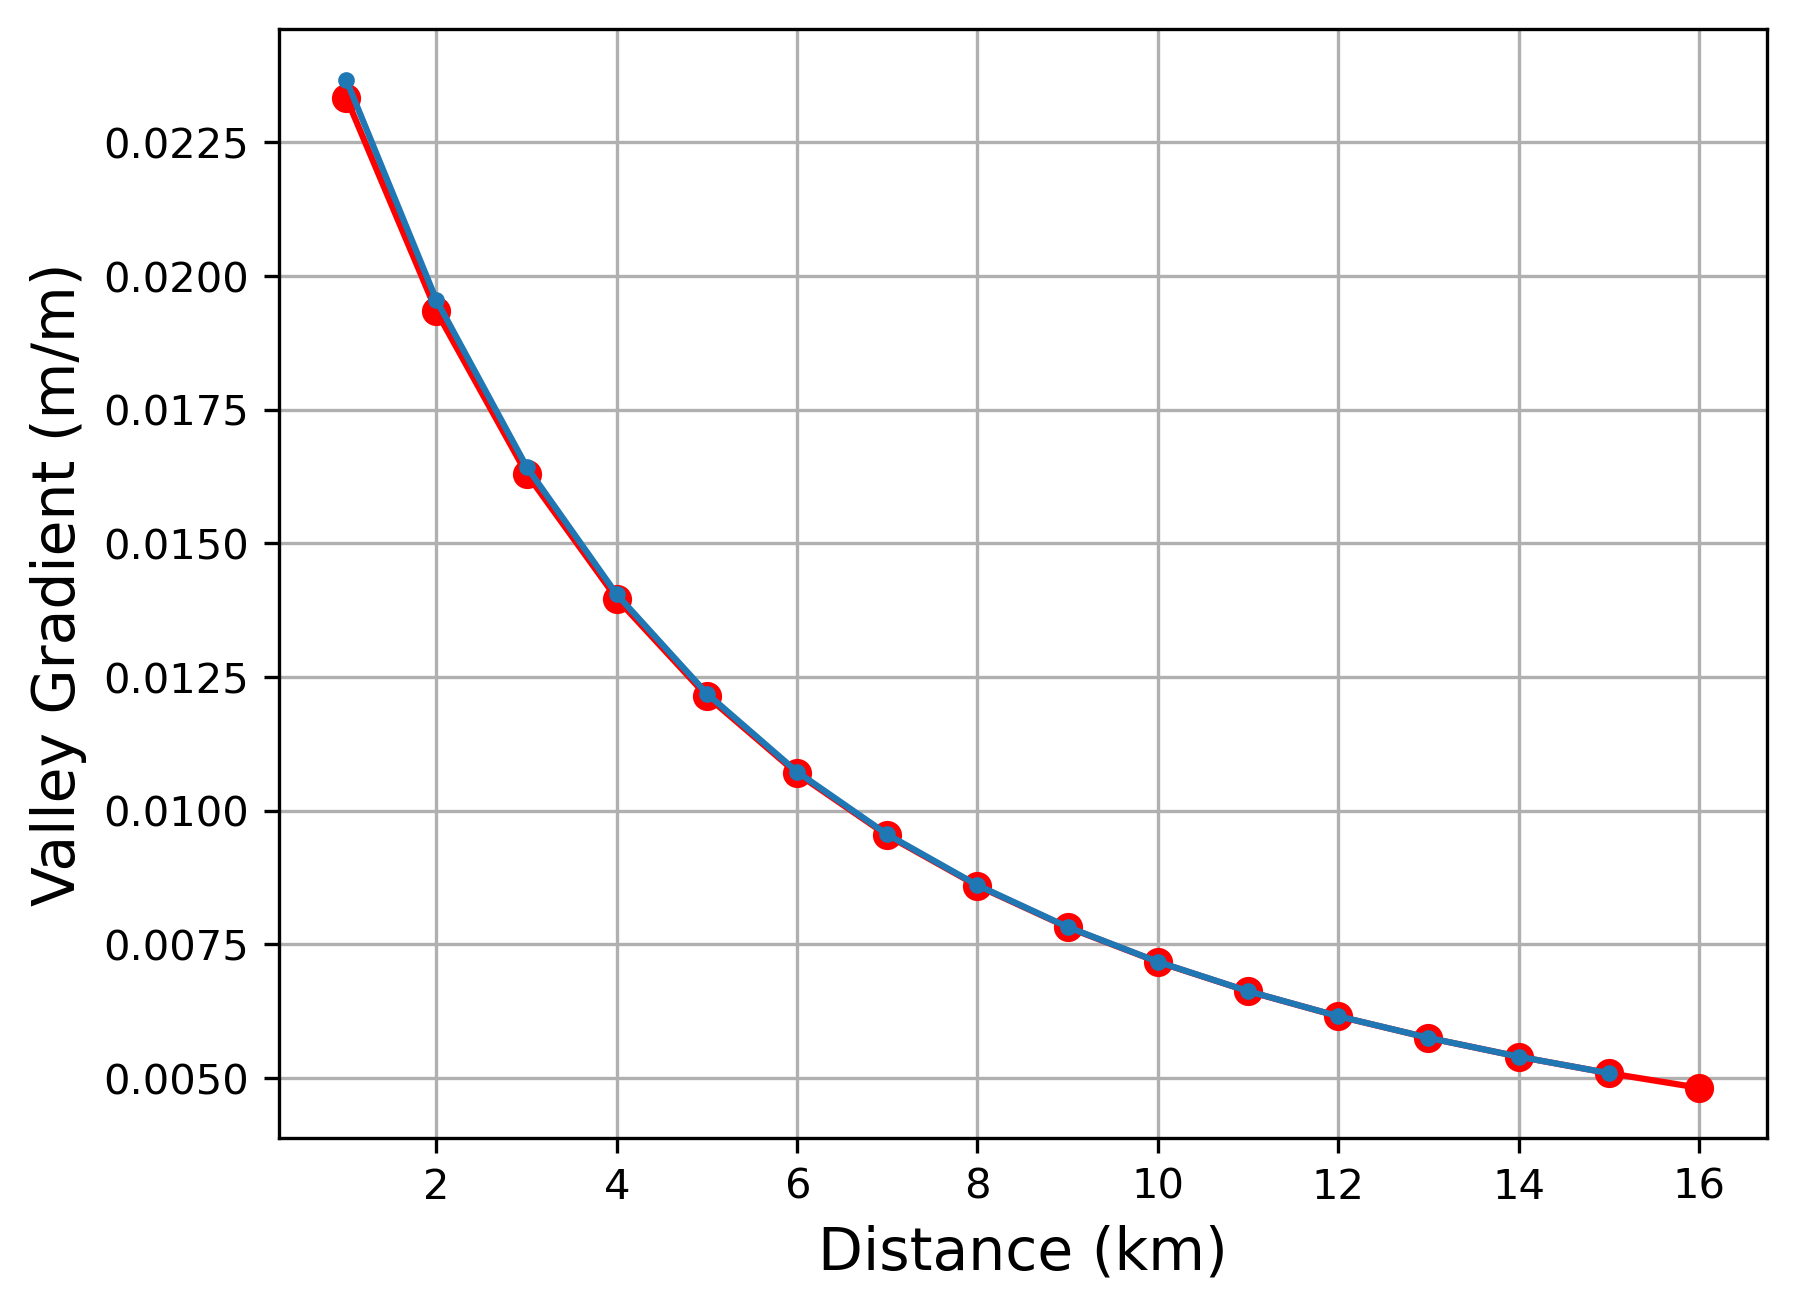

In [20]:
# Calculate analytical solution for gradient
Sfac = (1.0 - porosity) * uplift_rate / (abr_coef * xport_coef * imfac * bf_runoff_rate)
Spred = ((Sfac / profile_x) * (1.0 - np.exp(-abr_coef * profile_x))) ** (6.0 / 7.0)

# Plot
Smod = model.grid.at_node["topographic__steepest_slope"]
plt.plot(profile_x / 1000.0, Spred, "ro-")
plt.plot(profile_x[:-1] / 1000.0, Smod[midrow[:-1]], ".-")
plt.xlabel("Distance (km)", fontsize=14)
plt.ylabel("Valley Gradient (m/m)", fontsize=14)
plt.grid(True)

# Report
print("Predicted gradient at outlet:", Spred[-2])
print(
    "Computed gradient at outlet:",
    Smod[midrow[-2]],
)

The process of abrasion causes the equilibrium longitudinal profile to become concave-upward, because the water discharge increases faster downstream than the gravel flux.

The corresponding width no longer increases linearly downstream. Here it is with a median bed grain size of 5 cm:

Text(0, 0.5, 'Bankfull channel width (m)')

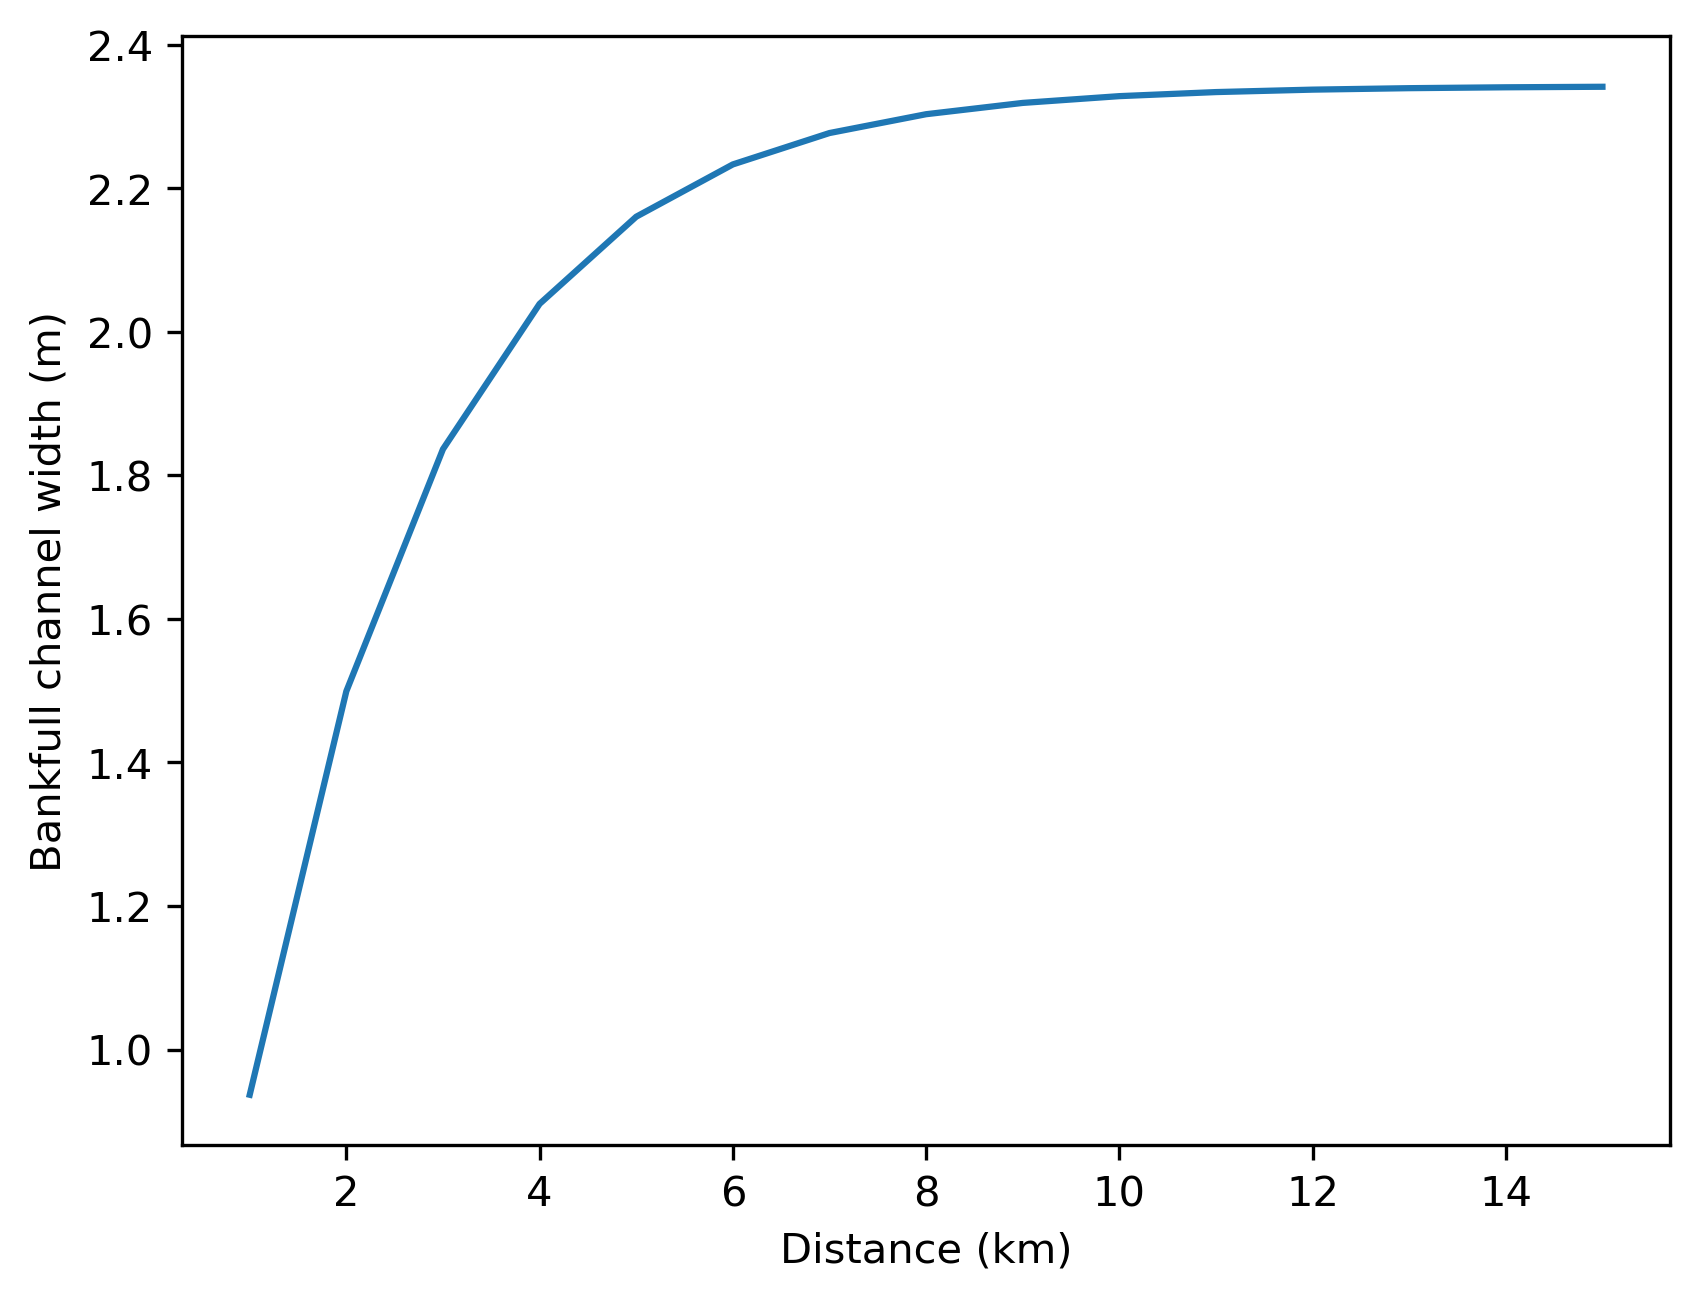

In [21]:
w = model.transporter.calc_implied_width(grain_diameter=0.05)
plt.plot(profile_x[:-1] / 1000.0, w[midrow[:-1]])
plt.xlabel("Distance (km)")
plt.ylabel("Bankfull channel width (m)")

In the foregoing example, we used a rather high abrasion coefficient. Attal & Lave (2006) report pebble abrasion coefficients ranging from 0.1 to 47 percent per km. The equivalent proportion per km is 0.001 to 0.47, and the equivalent length scales are the inverse of these. Here are some examples from their paper, in terms of length scale:

In [22]:
print("Quartzite:", 1.0 / 0.001, "km")
print("Granite:", 1.0 / 0.004, "km")
print("Gneiss:", 1.0 / 0.009, "km")
print("Ordovician limestone:", 1.0 / 0.026, "km")
print("Schist:", 1.0 / 0.07, "km")
print("Sandstone:", 1.0 / 0.47, "km")

Quartzite: 1000.0 km
Granite: 250.0 km
Gneiss: 111.11111111111111 km
Ordovician limestone: 38.46153846153846 km
Schist: 14.285714285714285 km
Sandstone: 2.127659574468085 km


Here's an example model run with a clast abrasion coefficient similar to that of their Himalayan gneiss:

In [23]:
# Parameters
abr_coef = 1.0 / 100000.0  # abrasion coefficient, 1/m
run_duration = 3.6e7  # run duration, years

In [24]:
profile_grid_params = {
    "RasterModelGrid": {
        "shape": (nrows, ncols),
        "xy_spacing": dx,
        "fields": {"node": {"topographic__elevation": {"constant": [{"value": 0.0}]}}},
    }
}

flow_params = {
    "flow_director": "FlowDirectorD8",
    "runoff_rate": bf_runoff_rate,
}

fluvial_params = {
    "intermittency_factor": imfac,
    "transport_coefficient": xport_coef,
    "abrasion_coefficient": abr_coef,
    "sediment_porosity": porosity,
}

In [25]:
model = GravelRiverNetworkModel(
    profile_grid_params,
    flow_params,
    fluvial_params,
    uplift_rate=uplift_rate,
    run_duration=run_duration,
    dt=dt,
    grid_setup_fn=channel_profile_setup,
    grid_setup_params={"init_slope": init_slope},
)

In [26]:
model.run()

Predicted gravel flux at outlet: 905.398153237 m3/y
Computed gravel flux at outlet: 905.404659574 m3/y


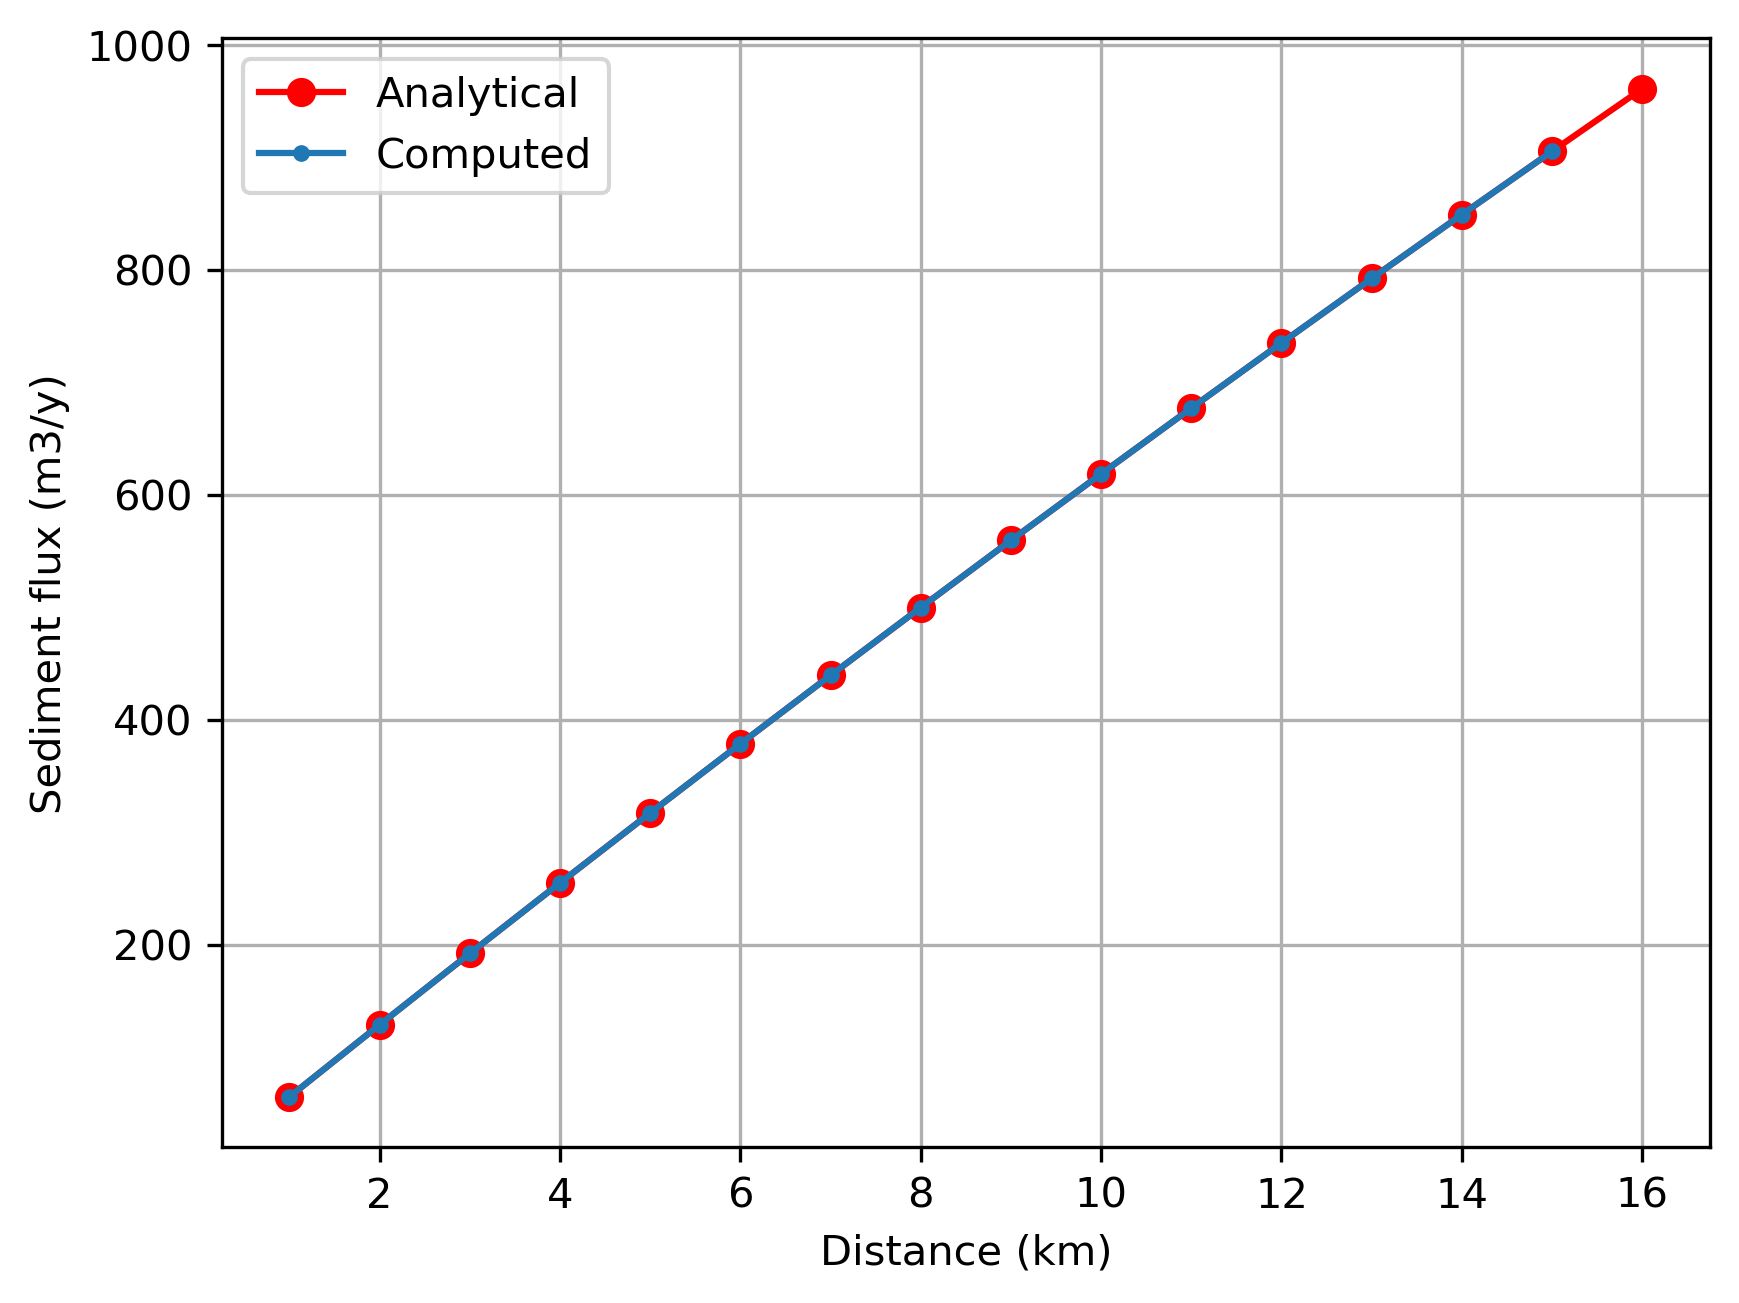

In [27]:
# Calculate analytical solution for gravel flux
Qseqb = (1.0 - porosity) * uplift_rate * dx / abr_coef
Qspred = Qseqb * (1.0 - np.exp(-abr_coef * profile_x))

# Plot
plt.plot(profile_x / 1000.0, Qspred, "ro-")
plt.plot(
    profile_x[:-1] / 1000.0,
    model.grid.at_node["bedload_sediment__volume_outflux"][midrow[:-1]],
    ".-",
)
plt.xlabel("Distance (km)")
plt.ylabel("Sediment flux (m3/y)")
plt.legend(["Analytical", "Computed"])
plt.grid(True)

# Report
print("Predicted gravel flux at outlet:", Qspred[-2], "m3/y")
print(
    "Computed gravel flux at outlet:",
    model.grid.at_node["bedload_sediment__volume_outflux"][midrow[-2]],
    "m3/y",
)

Predicted gradient at outlet: 0.0268957616453
Computed gradient at outlet: 0.0268959273115


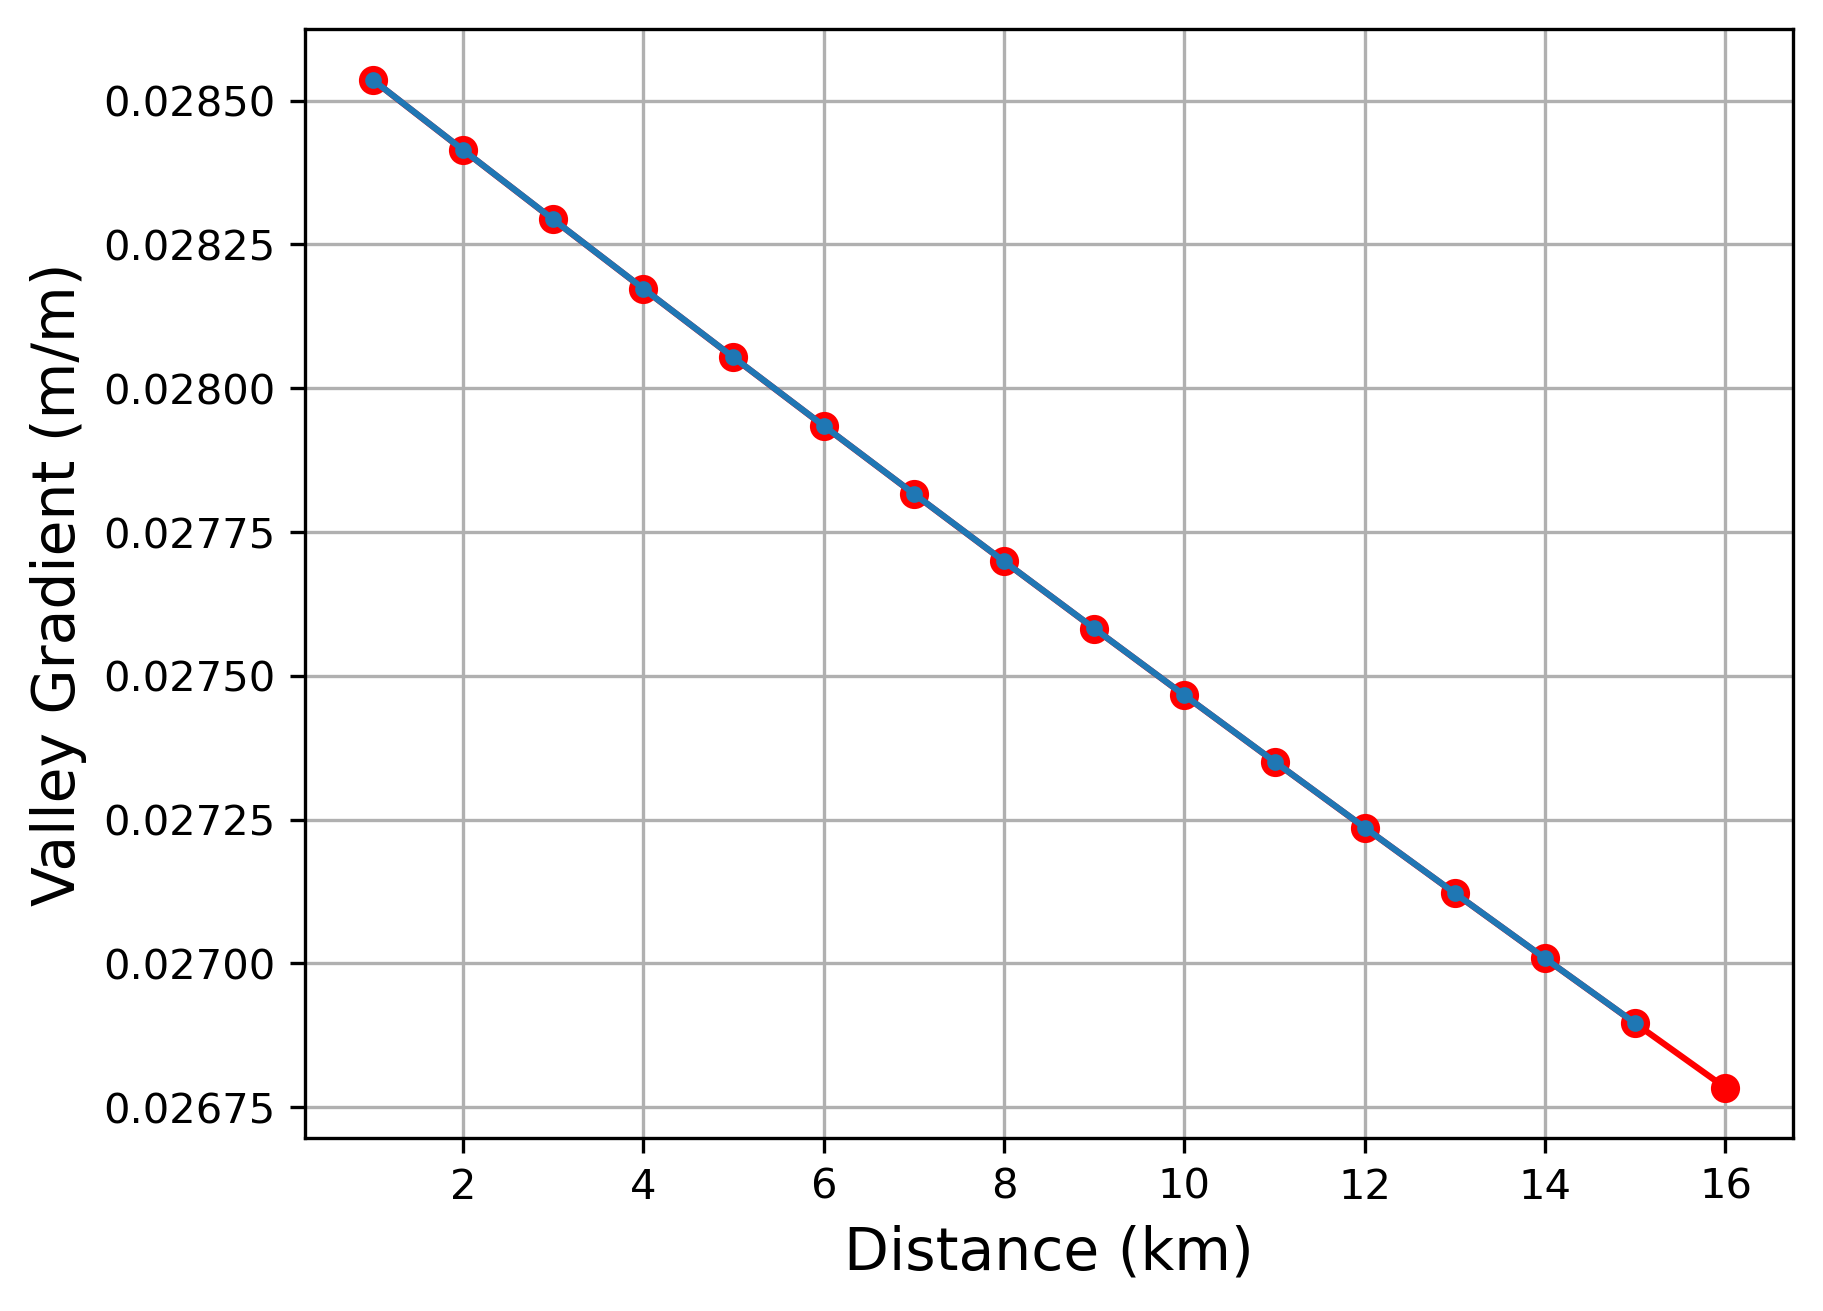

In [28]:
# Calculate analytical solution for gradient
Sfac = (1.0 - porosity) * uplift_rate / (abr_coef * xport_coef * imfac * bf_runoff_rate)
Spred = ((Sfac / profile_x) * (1.0 - np.exp(-abr_coef * profile_x))) ** (6.0 / 7.0)

# Plot
Smod = model.grid.at_node["topographic__steepest_slope"]
plt.plot(profile_x / 1000.0, Spred, "ro-")
plt.plot(profile_x[:-1] / 1000.0, Smod[midrow[:-1]], ".-")
plt.xlabel("Distance (km)", fontsize=14)
plt.ylabel("Valley Gradient (m/m)", fontsize=14)
plt.grid(True)

# Report
print("Predicted gradient at outlet:", Spred[-2])
print(
    "Computed gradient at outlet:",
    Smod[midrow[-2]],
)

Again, the gradient decreases down-valley, implying a concave-upward profile, but the comparatively more resistant clasts lead to a more gentle down-valley decrease in gradient.

## Example: tiny drainage basin

This example extends the domain to two dimensions, keeping the grid size very small (so the notebook runs fast), and comparing the equilibrium condition with analytical solutions for the sediment outflux and gradient at headwater nodes.

In [29]:
# Parameters
nrows = 10
ncols = 10
dx = 1000.0  # grid spacing, m
bf_runoff_rate = 10.0  # bankfull runoff rate, m/y
imfac = 0.01  # intermittency factor, -
xport_coef = 0.041  # transport coefficient, -
abr_coef = 1.0 / 2000.0  # abrasion coefficient, 1/m
porosity = 0.35  # sediment porosity, -
uplift_rate = 0.0001  # uplift (i.e., baselevel) rate, m/y

np.random.seed(0)

In [30]:
grid_params = {
    "RasterModelGrid": {
        "shape": (nrows, ncols),
        "xy_spacing": dx,
        "fields": {"node": {"topographic__elevation": {"constant": [{"value": 0.0}]}}},
    }
}

flow_params = {
    "flow_director": "FlowDirectorD8",
    "runoff_rate": bf_runoff_rate,
}

fluvial_params = {
    "intermittency_factor": imfac,
    "transport_coefficient": xport_coef,
    "abrasion_coefficient": abr_coef,
    "sediment_porosity": porosity,
}

In [31]:
# Define grid setup function for 3 rows with open boundary at right side


def mini_basin_setup(grid):
    """Set boundary nodes to CLOSED except the right side, which is the profile
    outlet; give"""
    grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED
    grid.status_at_node[1] = grid.BC_NODE_IS_FIXED_VALUE

In [32]:
model = GravelRiverNetworkModel(
    grid_params,
    flow_params,
    fluvial_params,
    initial_noise_amplitude=10.0,
    uplift_rate=uplift_rate,
    run_duration=5.0e5,
    dt=1000.0,
    grid_setup_fn=mini_basin_setup,
)

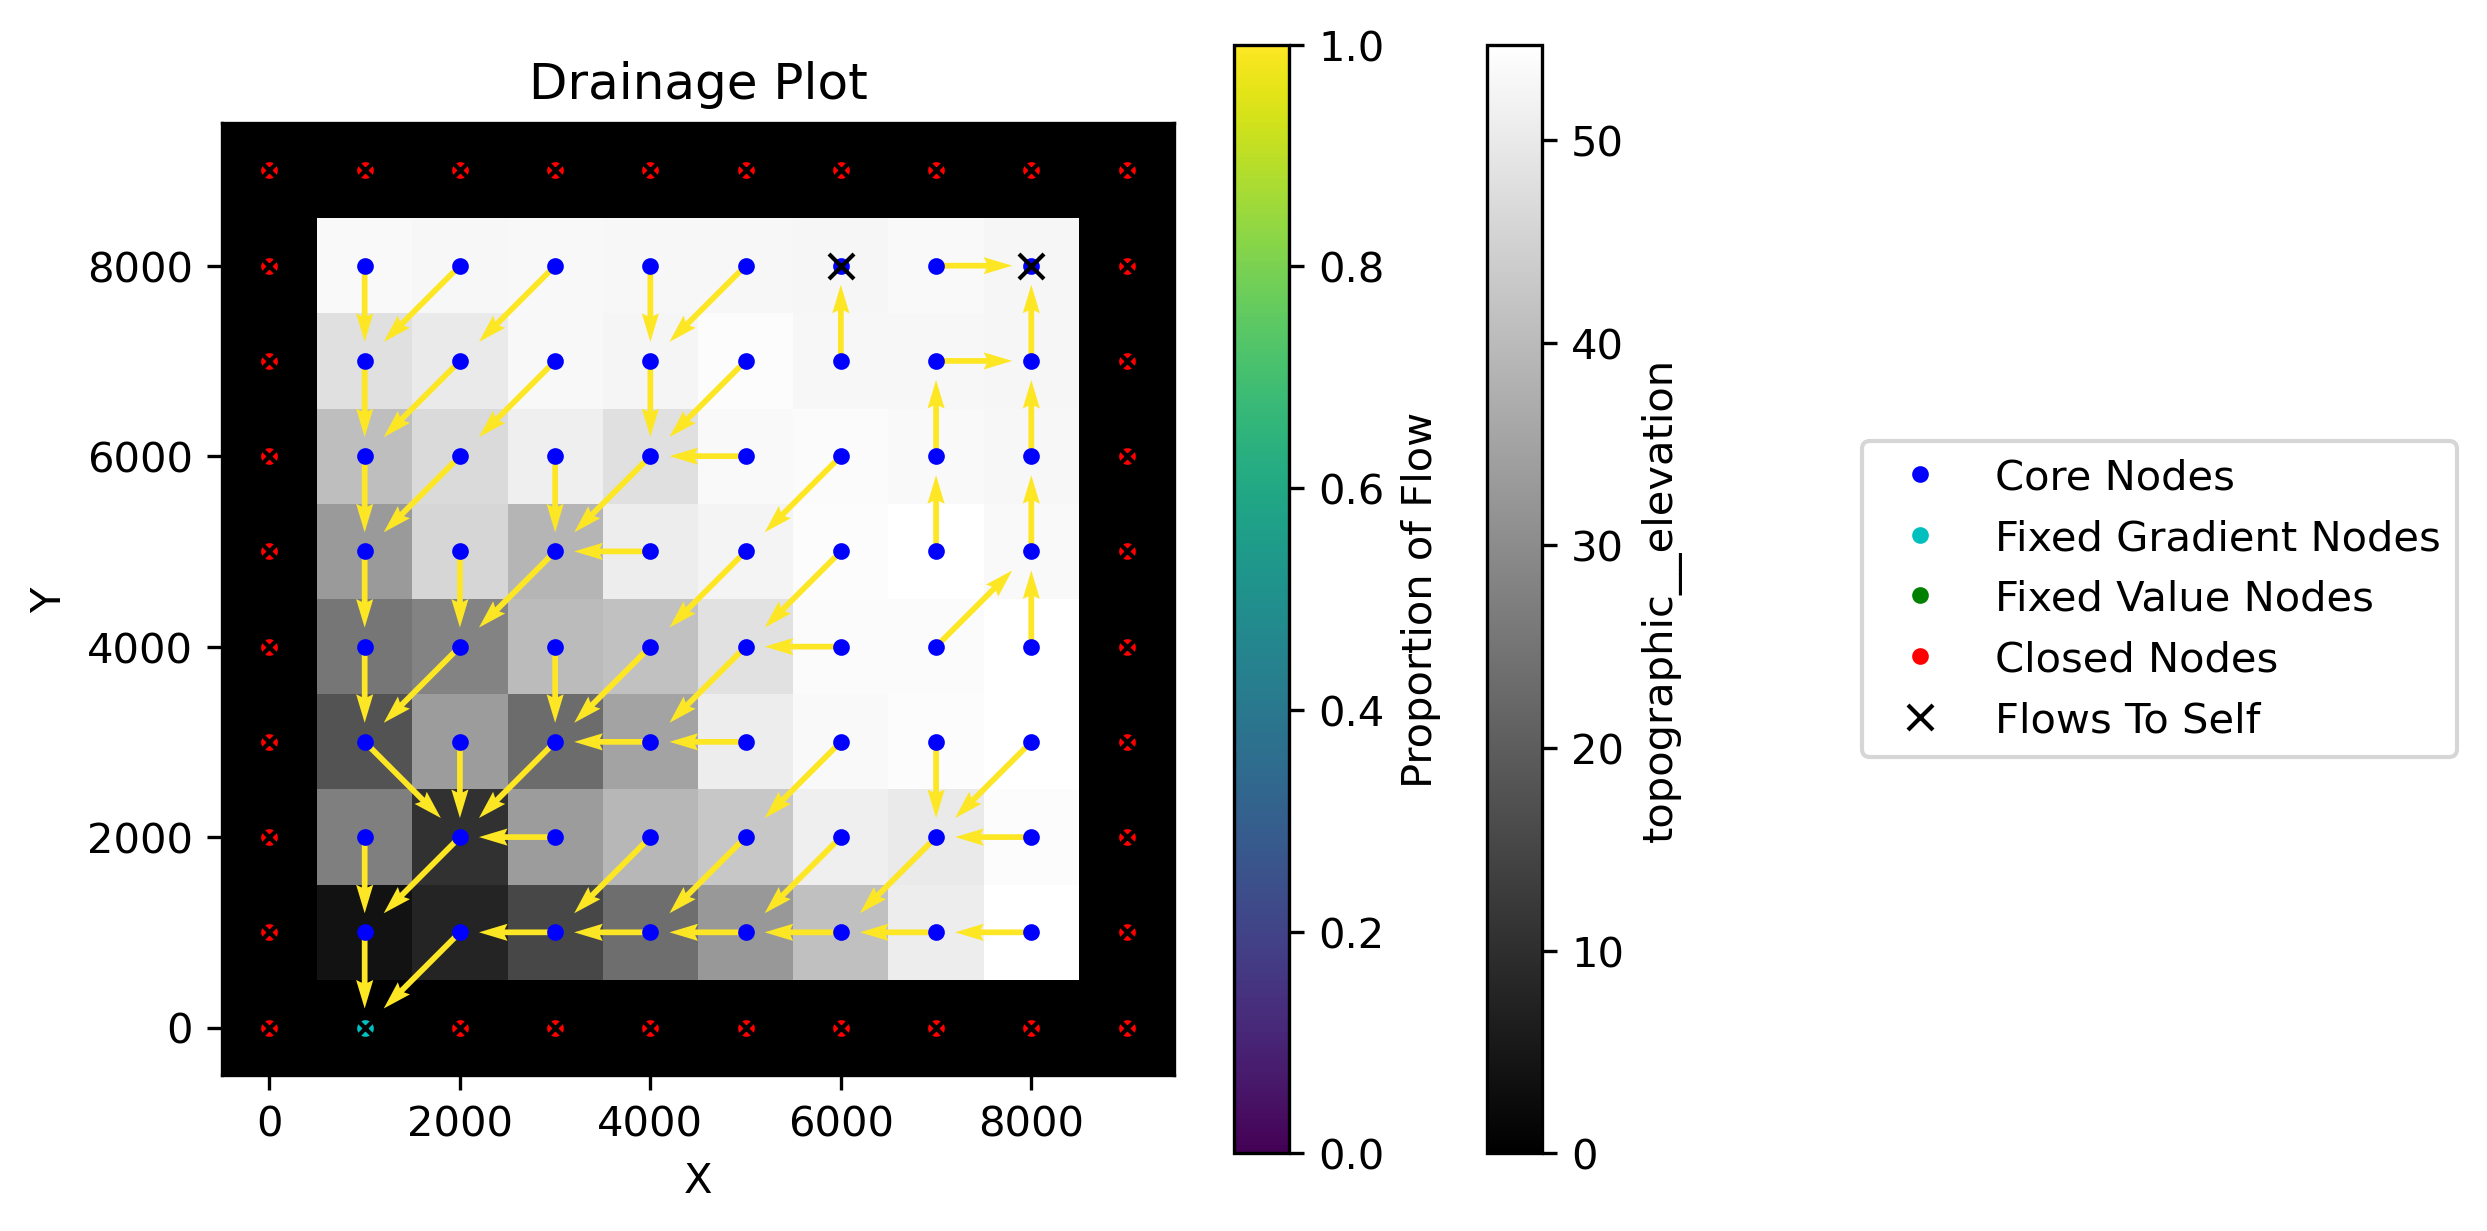

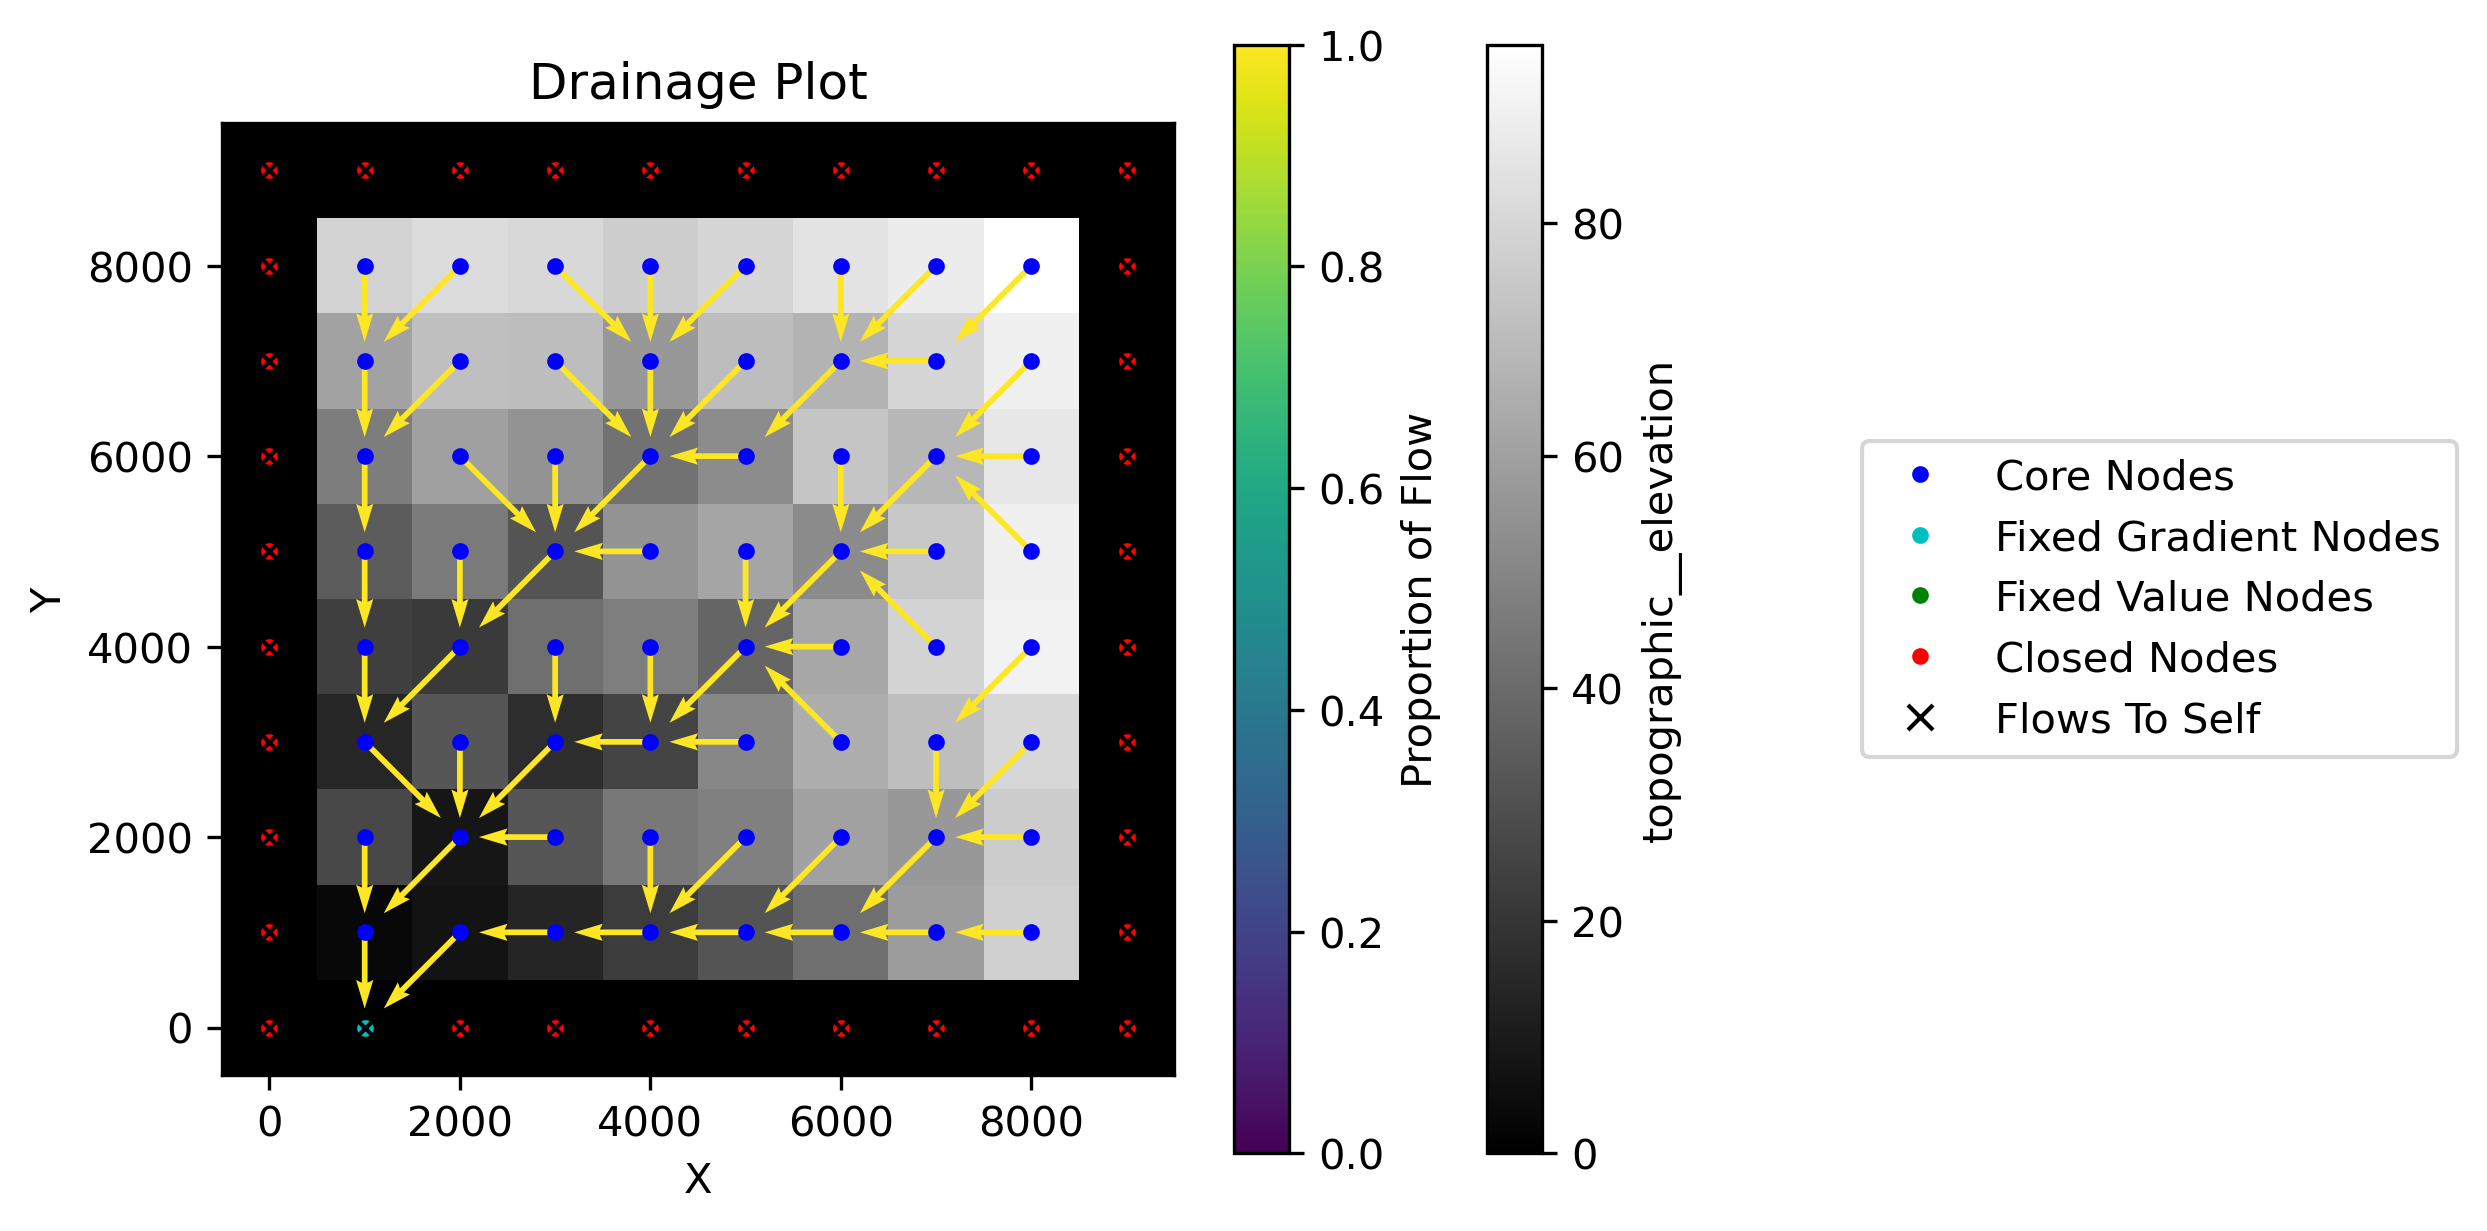

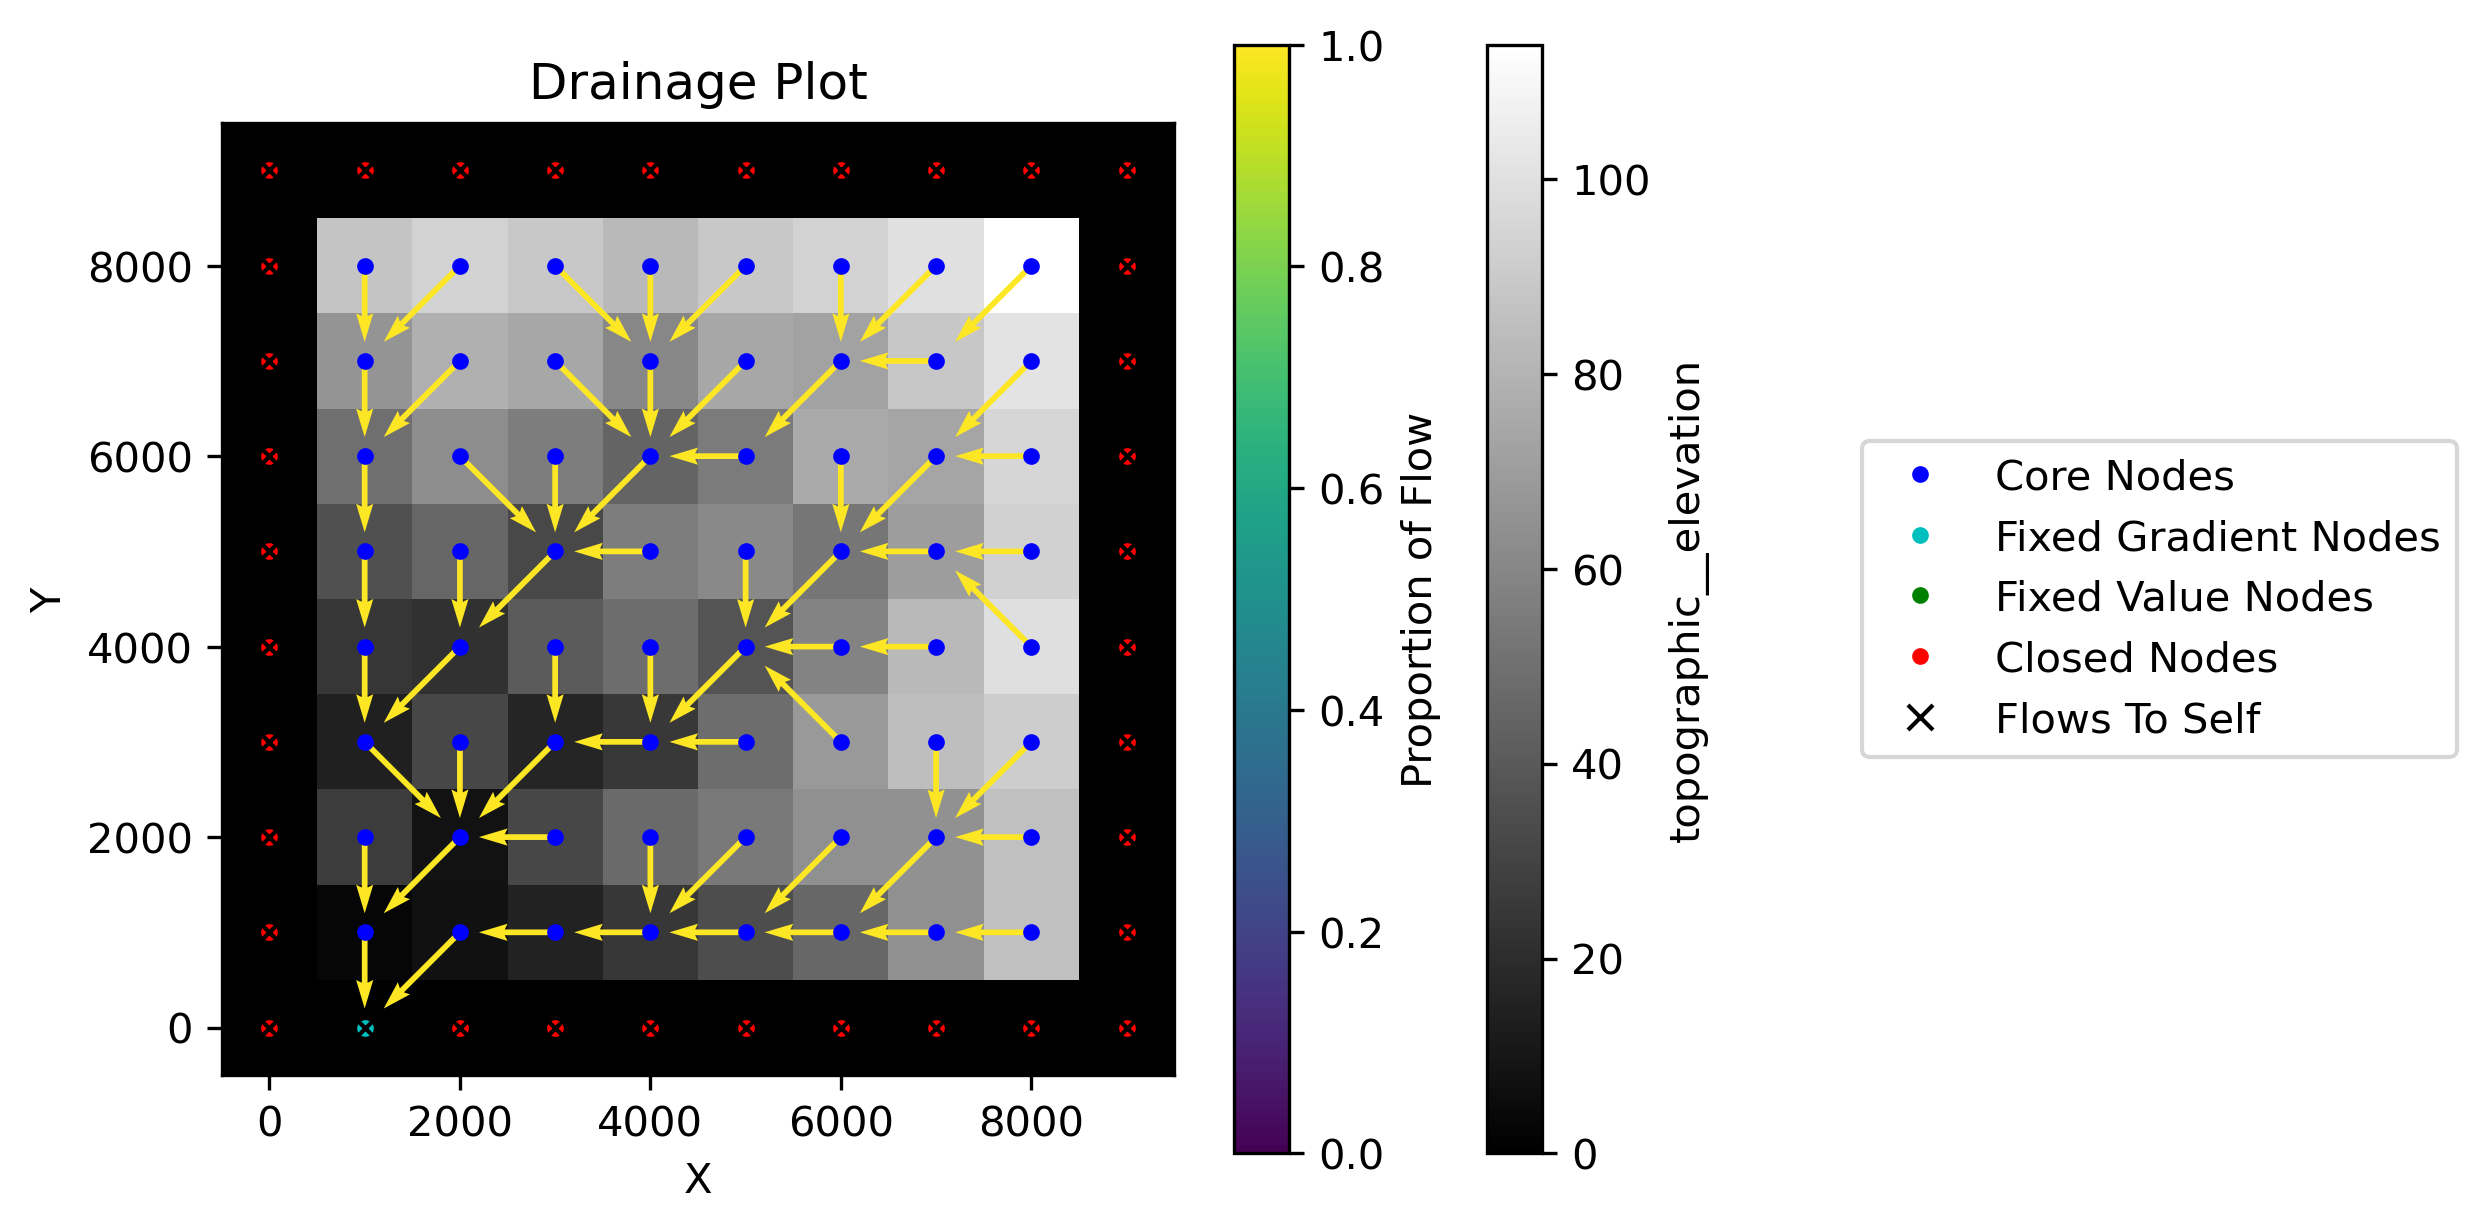

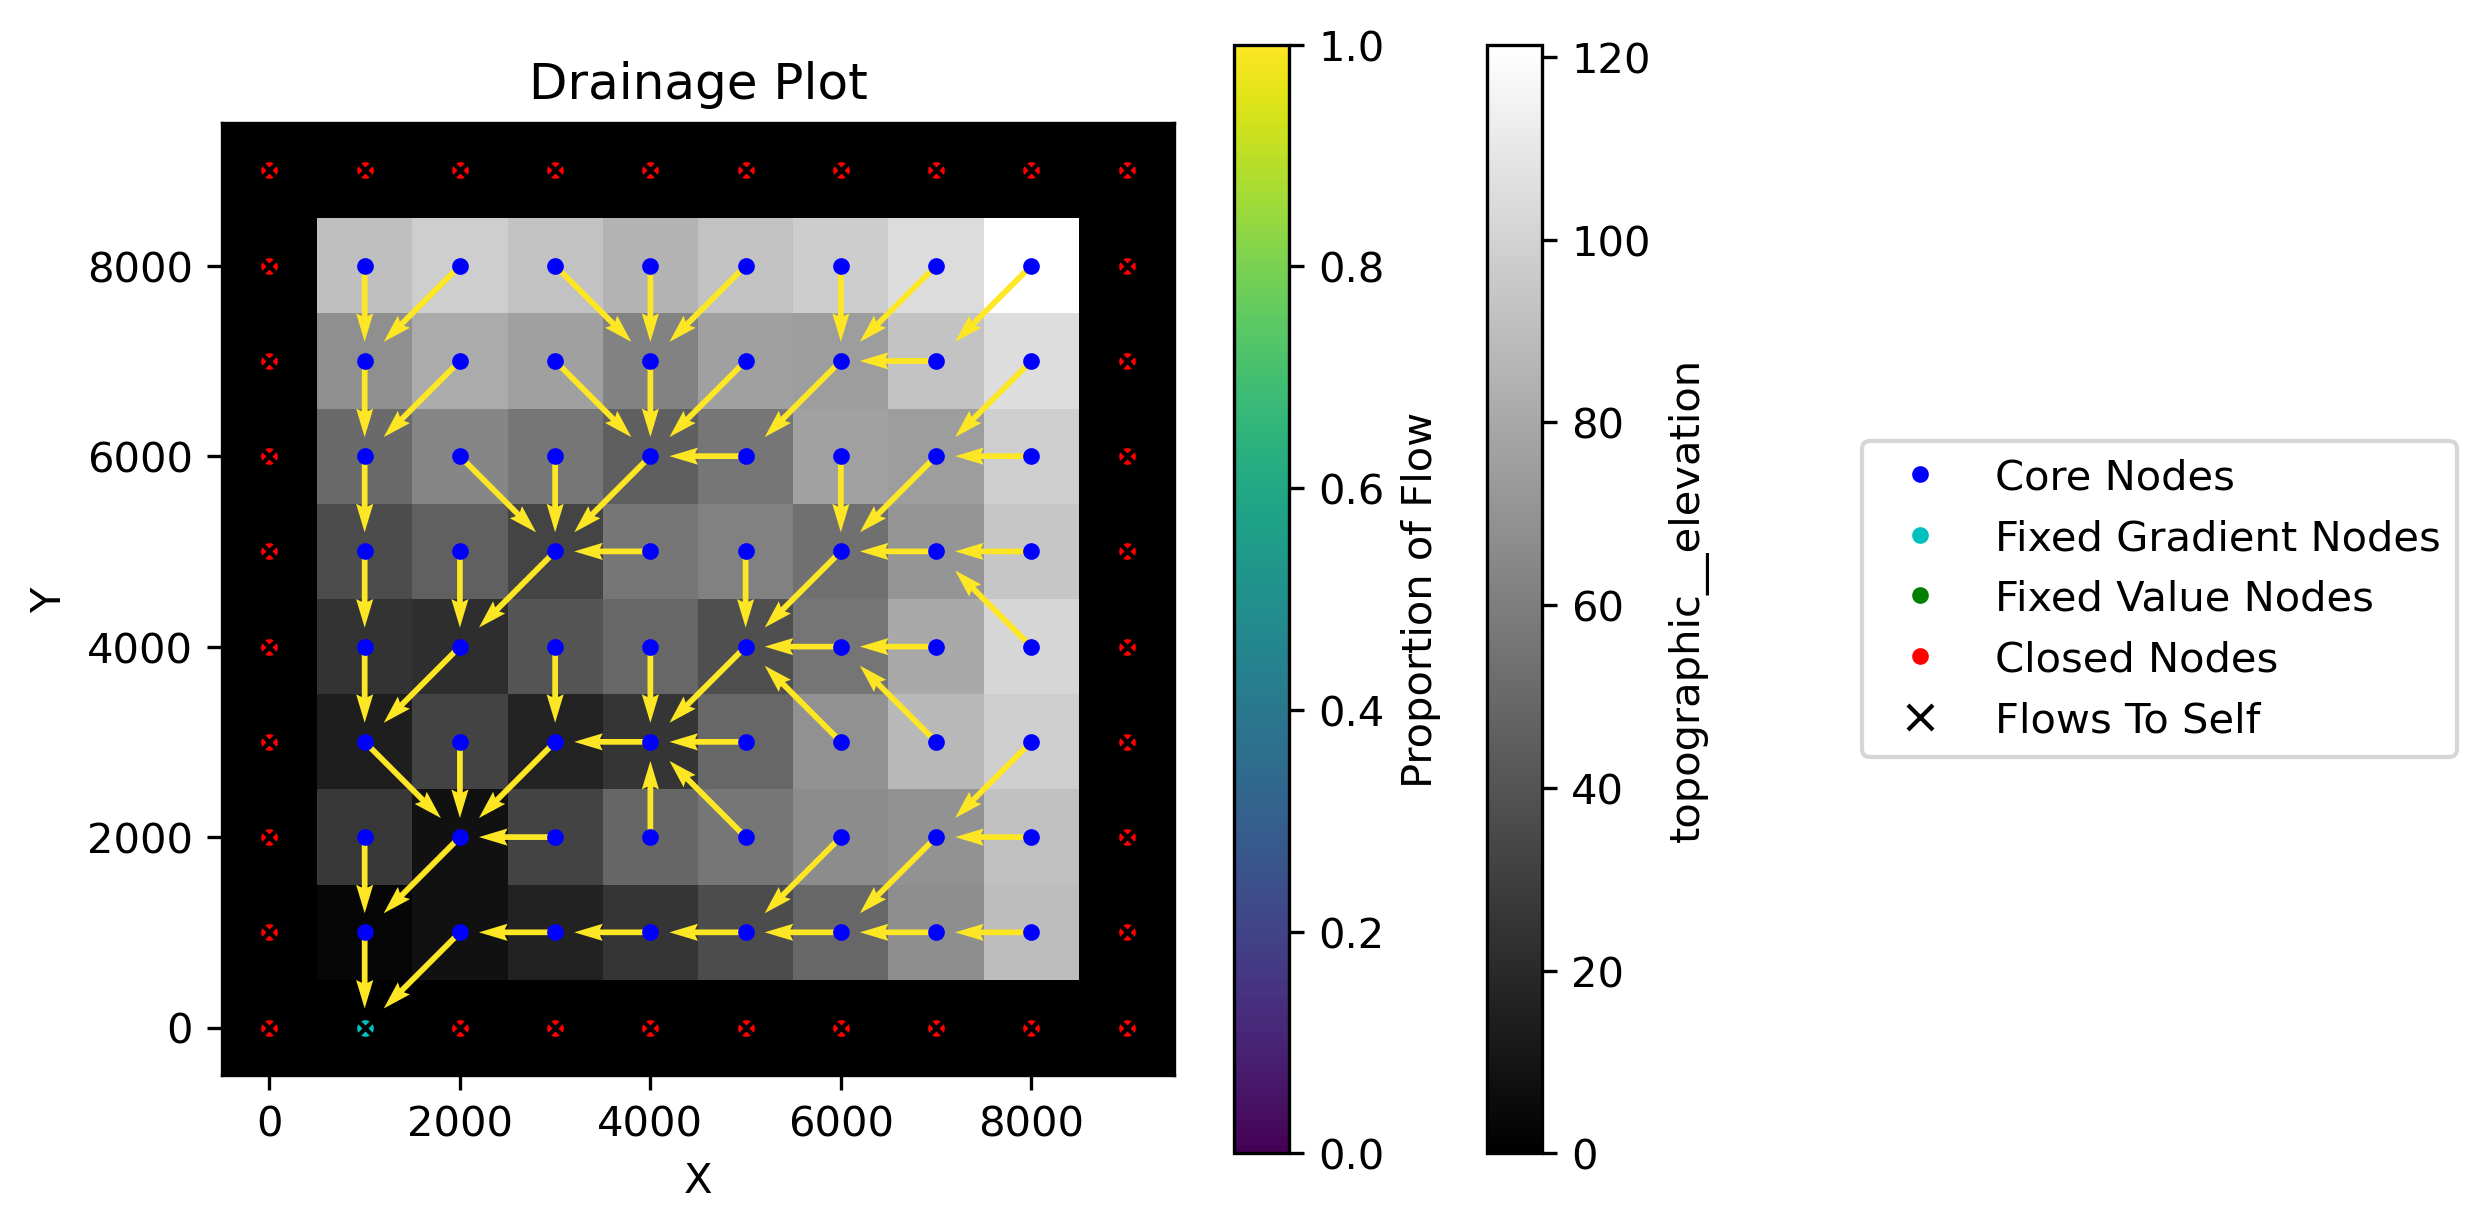

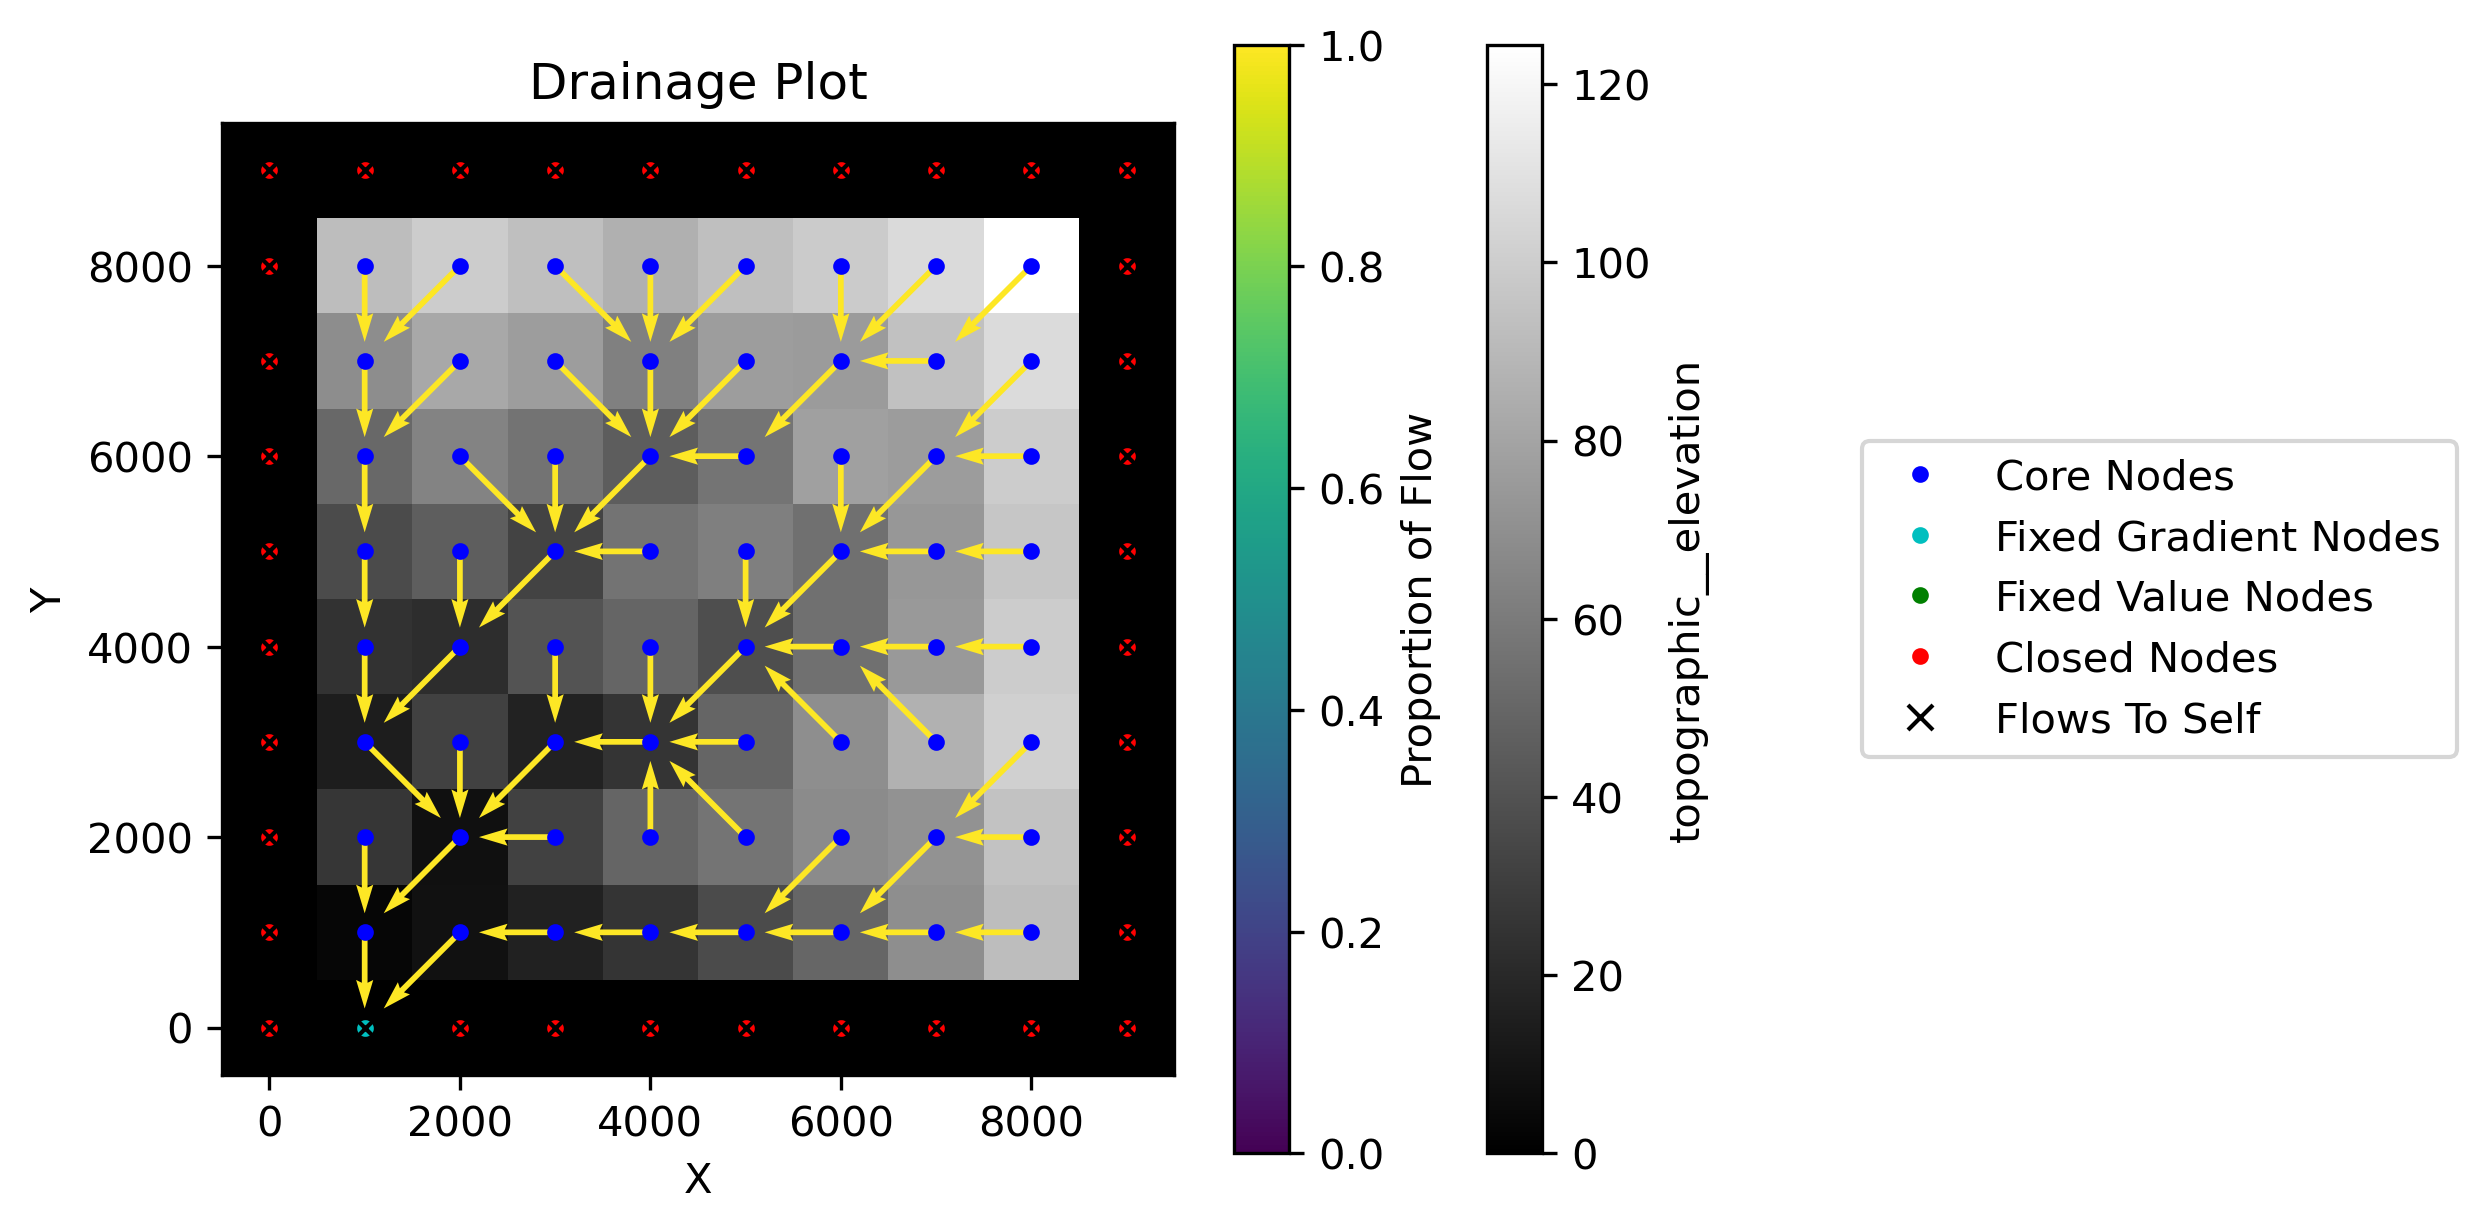

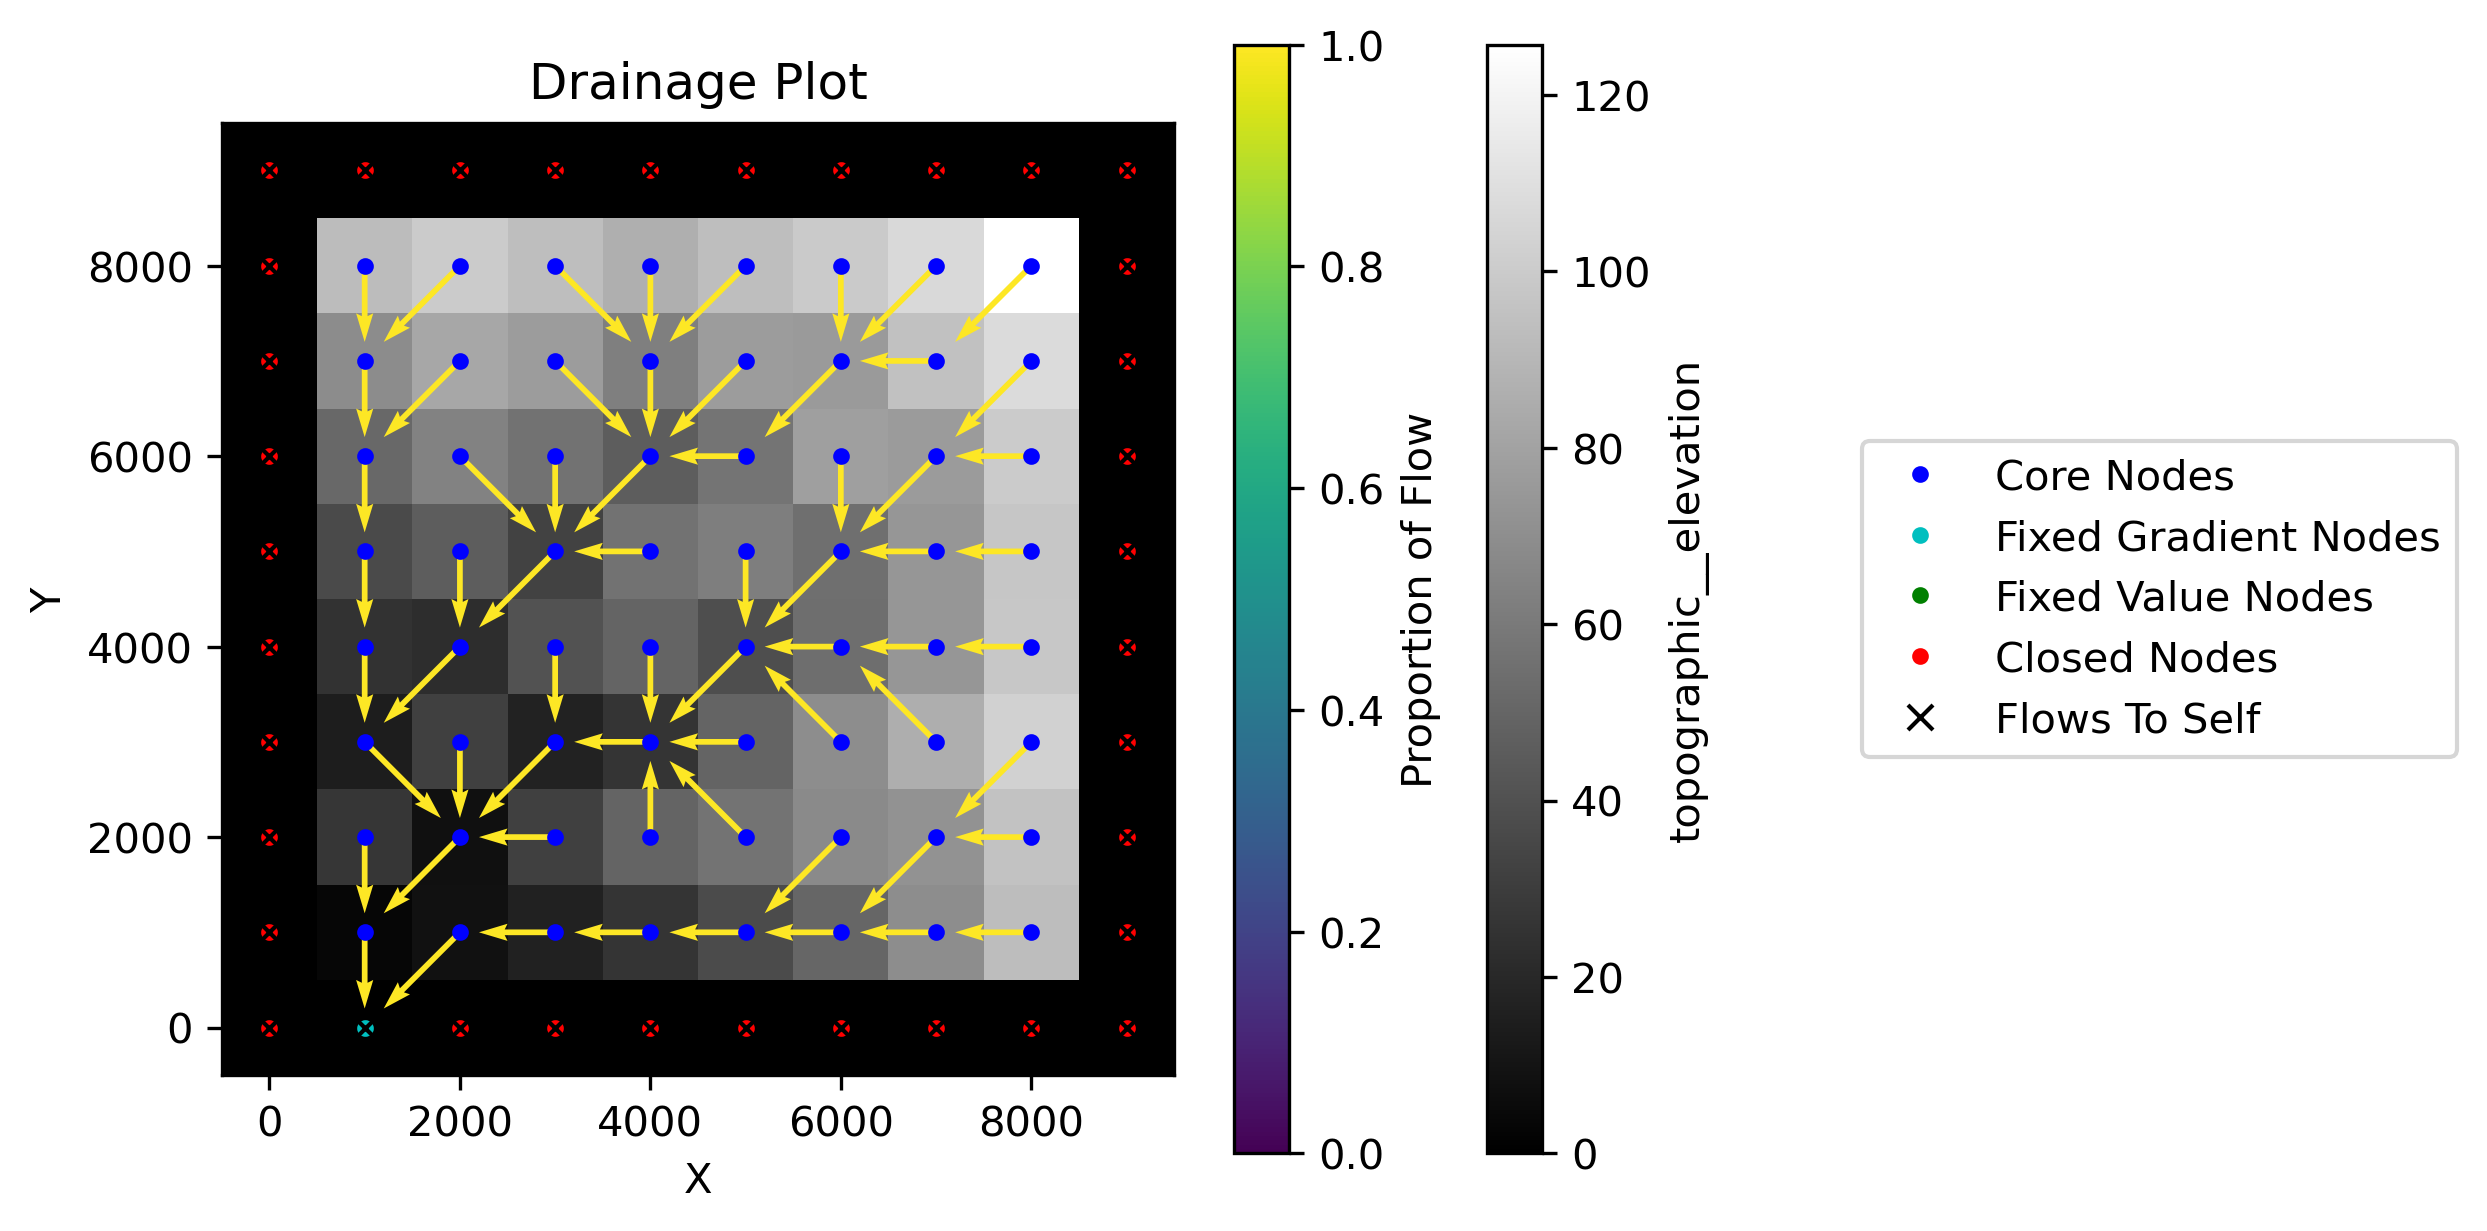

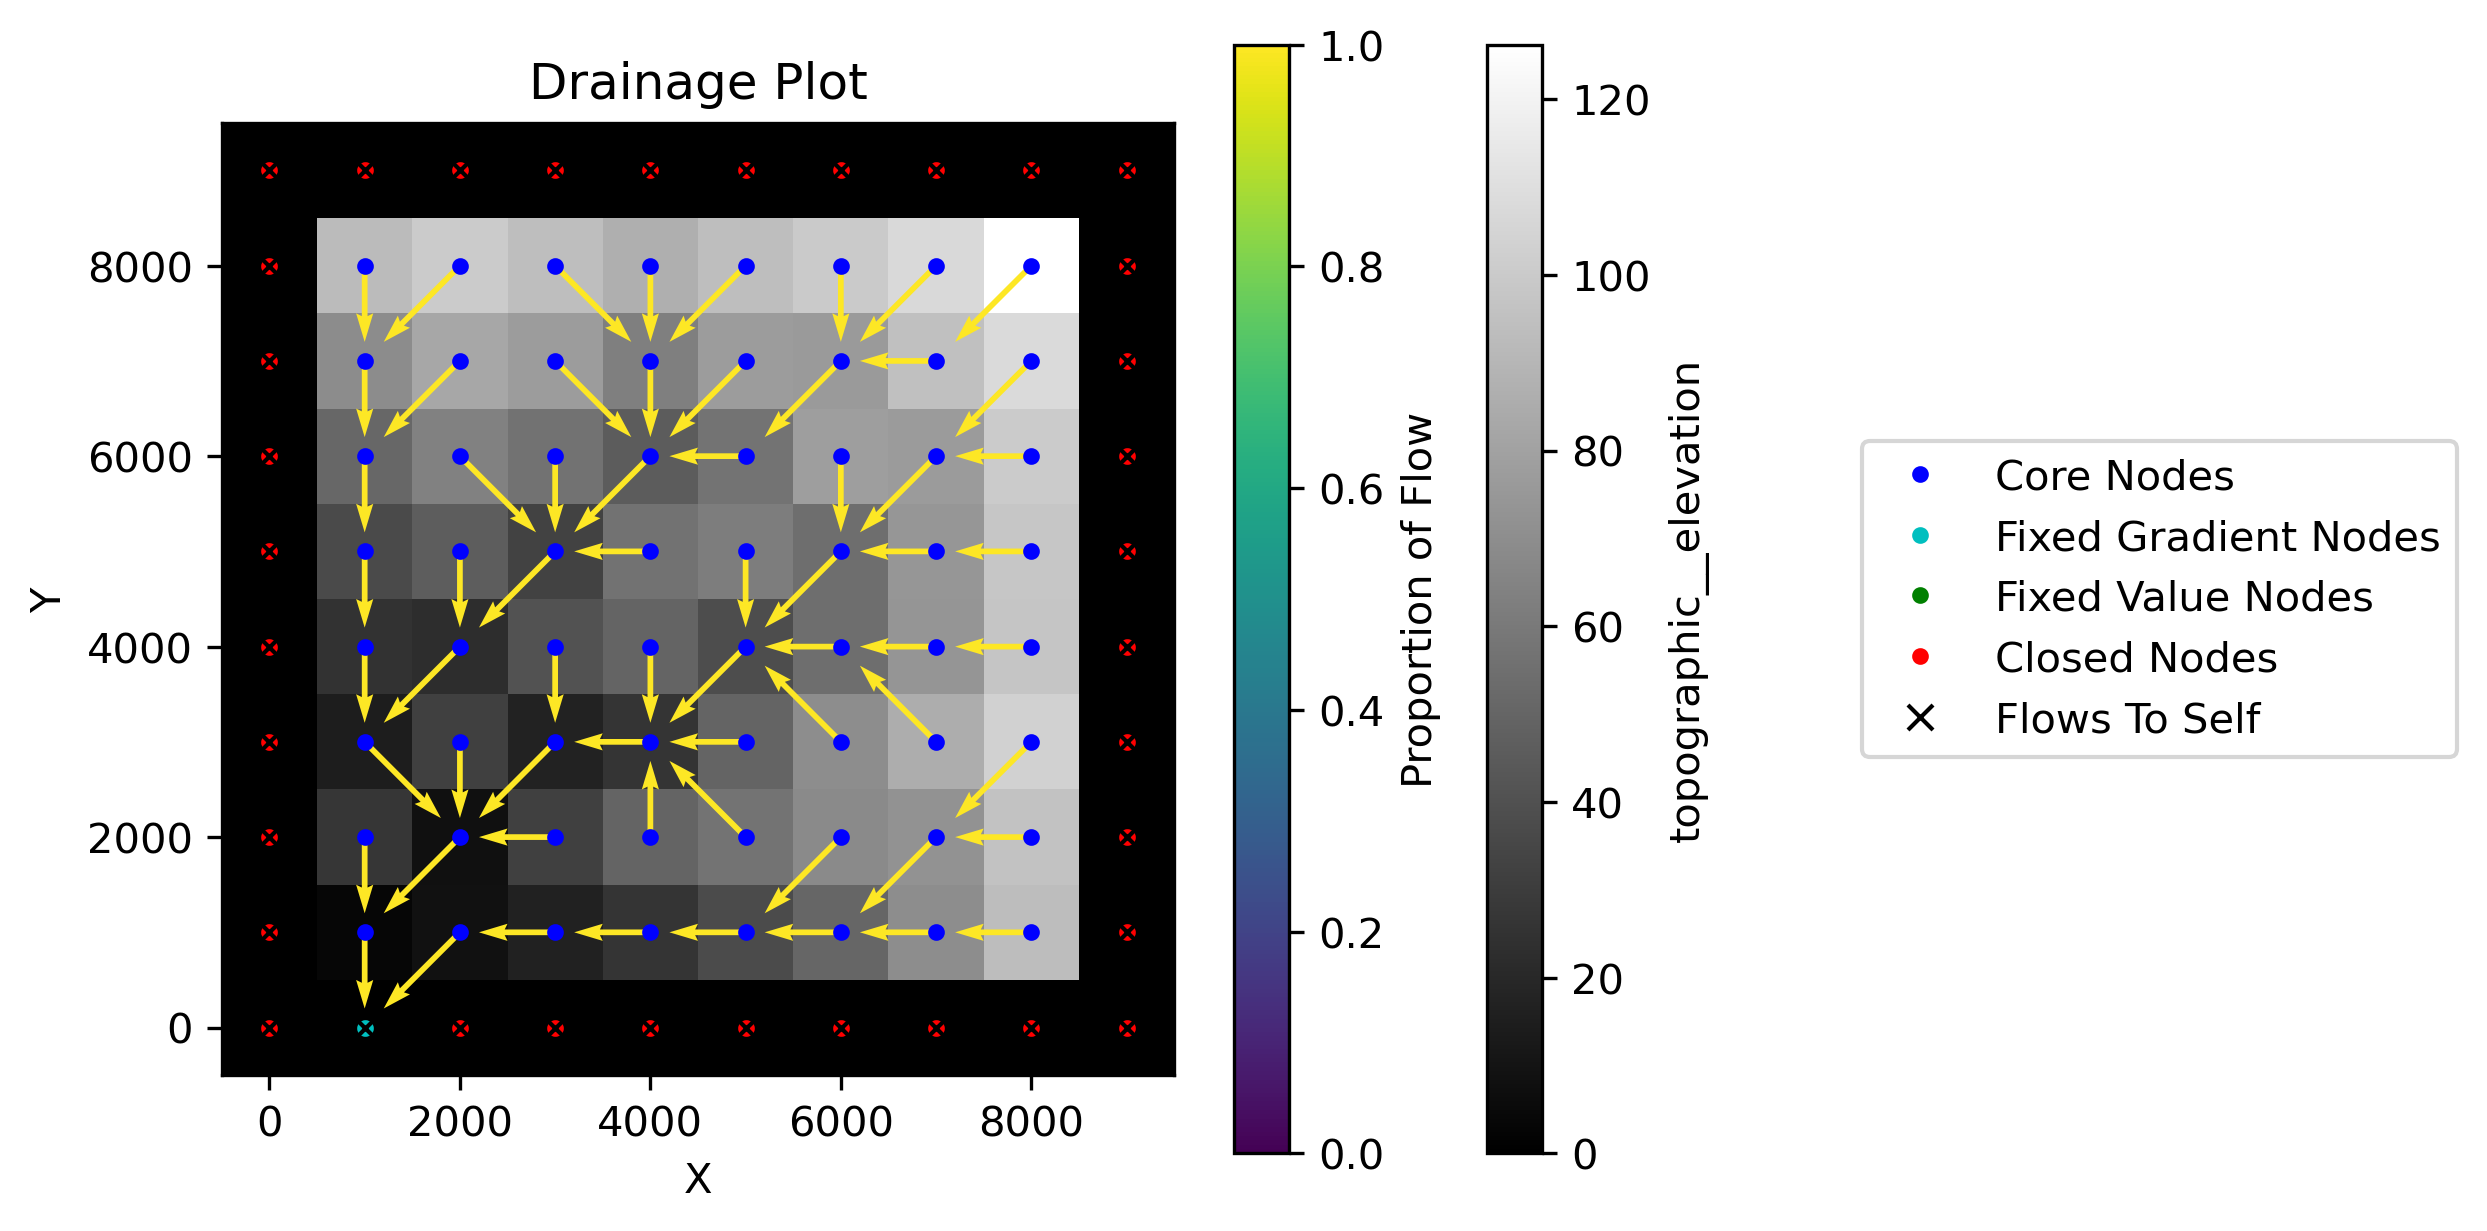

In [33]:
for _ in range(7):
    model.run()
    plt.figure()
    drainage_plot(model.grid)
    model.time_remaining += 5.0e5

The plots above illustrate a dendritic drainage network. We can also examine the slope-area relationship (see, e.g., Willgoose et al., 1991; Willgoose, 1994):

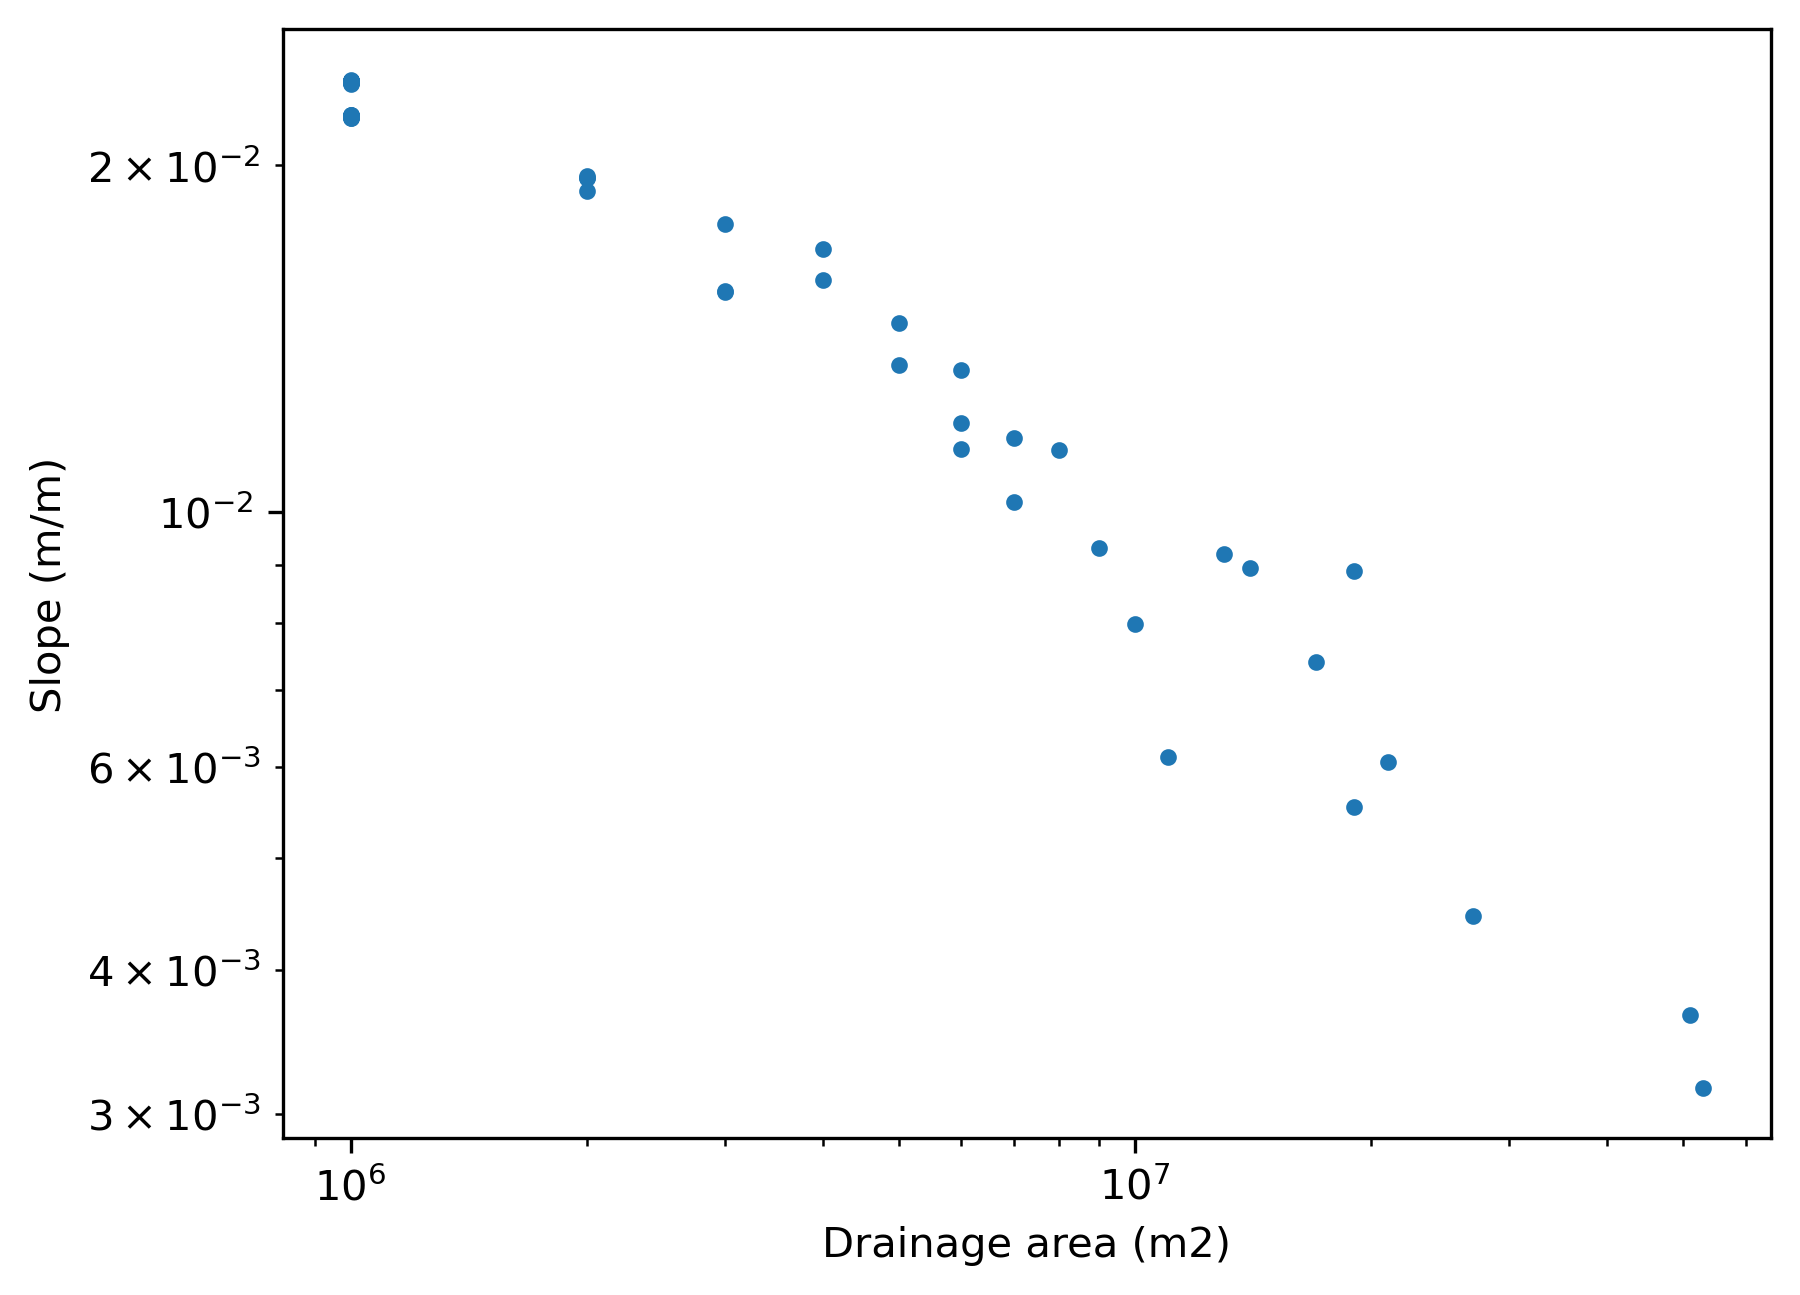

In [34]:
s = model.grid.at_node["topographic__steepest_slope"]
a = model.grid.at_node["drainage_area"]
cores = model.grid.core_nodes
plt.loglog(a[cores], s[cores], ".")
plt.xlabel("Drainage area (m2)")
_ = plt.ylabel("Slope (m/m)")

#### Test: sediment flux and slope at headwater cells

One way to test the steady mini-basin solution is to look at the headwater cells: those that receive no external water or sediment. When in equilibrium with a specified rate of baselevel lowering, a headwater cell should erode at the rate of baselevel lowering, $E$. This will effectively supply a quantity of sediment equal to the erosion rate times the cell area, $\Lambda$, times the solid fraction, so that we can express the volume inflow of sediment to the cell from erosional lowering as:

$$Q_\text{bl} = (1-\phi) E \Lambda$$

As sediment flows through and out of the cell, we should lose gravel to abrasion at a rate that depends on the abrasion coefficient, $\beta$, the local gravel flux $Q_s$, and the length of the channel, which here is treated as the length of the grid link along which water flows, $\lambda_f$:

$$Q_\text{abr} = \beta \lambda_f Q_s$$

In the component, the local sediment flux $Q_s$ is treated as the average of the incoming flux, $Q_\text{in}$, and the outgoing flux, $Q_\text{out}$. In a headwater cell, there's no influx, so the average of in and outflux is evaluated as $Q_s = Q_\text{out} / 2$, and hence

$$Q_\text{abr} = \beta \lambda_f Q_\text{out} / 2$$

At equilibrium, the volume rate of sediment addition via erosional lowering equals the sum of the abrasion loss rate and the downstream transport rate:

$$Q_\text{bl} = Q_\text{out} + Q_\text{abr}$$

Substituting the above, we can rearrange like so:

$$Q_\text{out} = (1-\phi) E \Lambda - \beta \lambda_f Q_\text{out} / 2$$

and then solve for the expected sediment outflux from a headwater cell:

$$\boxed{Q_\text{out} = \frac{(1-\phi) E \Lambda}{1 + \beta \lambda_f / 2}}$$

Using the transport equation, we can then solve for the expected gradient of headwater cells. In doing so, we use the fact that $Q = r A$ and in this case $A = \Lambda$ (i.e., drainage area equals the cell area, because there is no inflow of water besides local runoff generation):

$$\boxed{S = \left( \frac{(1-\phi) E}{k_Q I r \left( 1 + \beta \lambda_f / 2 \right)} \right)^{6/7}}$$

The code below tests this for headwater cells. Note that on a raster grid with D8 flow routing, $\lambda_f$ will differ between cardinal and diagonal directions, so we will calculate the expected flux and gradient for both cases.

In [35]:
# Get an array of headwater node ids
hw = np.where(model.grid.at_node["drainage_area"] == 1.0e6)[0]
print("There are", len(hw), "headwater nodes.")

# Calculate the expected sediment outflux for cardinal & diagonal dirs
Qoutpred = (1 - porosity) * uplift_rate * dx * dx / (1 + abr_coef * dx / 2)
Qoutpred_diag = (1 - porosity) * uplift_rate * dx * dx / (1 + abr_coef * dx / 2**0.5)
print()
print("Predicted outflux for cardinal directions:", Qoutpred)
print("Predicted outflux for diagonal directions:", Qoutpred_diag)

# Actual outflux for headwater nodes:
print()
print("Modeled outflux:")
print(model.grid.at_node["bedload_sediment__volume_outflux"][hw])

There are 35 headwater nodes.

Predicted outflux for cardinal directions: 52.0
Predicted outflux for diagonal directions: 48.02174812735681

Modeled outflux:
[ 51.76685788  51.99928298  51.99751326  51.99149755  48.00695091
  47.92648013  51.713966    51.99751321  51.99174123  48.00679575
  48.10174306  47.69322572  51.99515807  51.99170396  52.18816174
  51.98623726  51.97319509  51.99011375  51.8463929   47.99134261
  51.97319545  51.93899177  51.85367563  47.94525841  47.96195939
  47.96198629  47.84797905  51.88541661  47.88857469  47.91874203
  51.91012062  47.91866326  51.83667642  47.8368702   47.71768559]


As predicted, there are some locations consistent with a cardinal-direction outflow, and some with a diagonal outflow. (On a hex grid, this would not be an issue.) The modeled values are slightly lower than the analytical predictions, in part because we are not yet 100% at steady state (just very close).

Next, we inspect the corresponding slope gradients:

In [36]:
# Calculate expected gradients
Shwpred = (
    (1 - porosity)
    * uplift_rate
    / (xport_coef * imfac * bf_runoff_rate * (1 + abr_coef * dx / 2))
) ** (6.0 / 7.0)
Shwpred_diag = (
    (1 - porosity)
    * uplift_rate
    / (xport_coef * imfac * bf_runoff_rate * (1 + abr_coef * dx / 2**0.5))
) ** (6.0 / 7.0)
print("Predicted gradient for cardinal-direction outflow:", Shwpred)
print("Predicted gradient for diagonal outflow:", Shwpred_diag)

# Compare with actual gradients
print()
print("Computed gradients at headwater nodes:")
print(s[hw])

Predicted gradient for cardinal-direction outflow: 0.023669448101592088
Predicted gradient for diagonal outflow: 0.02210857059783792

Computed gradients at headwater nodes:
[ 0.02357846  0.02366917  0.02366848  0.02366613  0.02210273  0.02207097
  0.02355781  0.02366848  0.02366623  0.02210267  0.02214013  0.02197887
  0.02366756  0.02366621  0.02374284  0.02366408  0.02365899  0.02366559
  0.0236095   0.02209657  0.02365899  0.02364564  0.02361235  0.02207838
  0.02208497  0.02208499  0.02203998  0.02362474  0.02205601  0.02206792
  0.02363438  0.02206789  0.02360571  0.02203559  0.02198853]


Again, as expected, the slopes are consistent with the predictions for both flow directions. The headwater cells with diagonal outflow directions have a slightly lower gradient because the longer flow paths allow for more gravel attrition. As before, the modeled values are slightly lower than predicted because the run has not fully reached steady state.

## Example: transient erosion and deposition

This example illustrates the ability of the model to calculate deposition as well as erosion. Here we use a domain that has a sine-curve-shaped valley along one axis, with an abrupt step in the middle of the valley. We expect erosion to occur upstream of the step, and deposition downstream.

In [37]:
# Parameters
nrows = 11
ncols = 50
dx = 1000.0  # grid spacing, m
init_elev_plateau = 100.0
init_slope = 0.0001
bf_runoff_rate = 10.0  # bankfull runoff rate, m/y
imfac = 0.01  # intermittency factor, -
xport_coef = 0.041  # transport coefficient, -
abr_coef = 0.0  # abrasion coefficient, 1/m
porosity = 0.35  # sediment porosity, -
uplift_rate = 0.0  # uplift (i.e., baselevel) rate, m/y
nsteps = 1000  # number of time steps
dt = 100.0  # duration of a time step, y

In [38]:
grid_params = {
    "RasterModelGrid": {
        "shape": (nrows, ncols),
        "xy_spacing": dx,
        "fields": {"node": {"topographic__elevation": {"constant": [{"value": 0.0}]}}},
    }
}

flow_params = {
    "flow_director": "FlowDirectorD8",
    "runoff_rate": bf_runoff_rate,
}

fluvial_params = {
    "intermittency_factor": imfac,
    "transport_coefficient": xport_coef,
    "abrasion_coefficient": abr_coef,
    "sediment_porosity": porosity,
}

In [39]:
# Define grid setup function for a valley with a step


def valley_with_step_setup(grid, init_slope, init_elev_plateau):
    """Create a sine-shaped valley with a step."""
    grid.status_at_node[grid.perimeter_nodes] = grid.BC_NODE_IS_CLOSED
    grid.status_at_node[grid.nodes_at_right_edge] = grid.BC_NODE_IS_FIXED_VALUE
    elev = grid.at_node["topographic__elevation"]
    elev[grid.x_of_node <= dx * ncols // 2] += init_elev_plateau
    xmax = np.amax(grid.x_of_node)
    elev[:] += init_slope * (xmax - grid.x_of_node)
    elev[:] += 10.0 * np.sin(2 * np.pi * grid.y_of_node / (dx * 10) + np.pi / 2.0)

In [40]:
model = GravelRiverNetworkModel(
    grid_params,
    flow_params,
    fluvial_params,
    initial_noise_amplitude=0.0,
    uplift_rate=uplift_rate,
    run_duration=nsteps * dt,
    dt=dt,
    grid_setup_fn=valley_with_step_setup,
    grid_setup_params={
        "init_slope": init_slope,
        "init_elev_plateau": init_elev_plateau,
    },
)

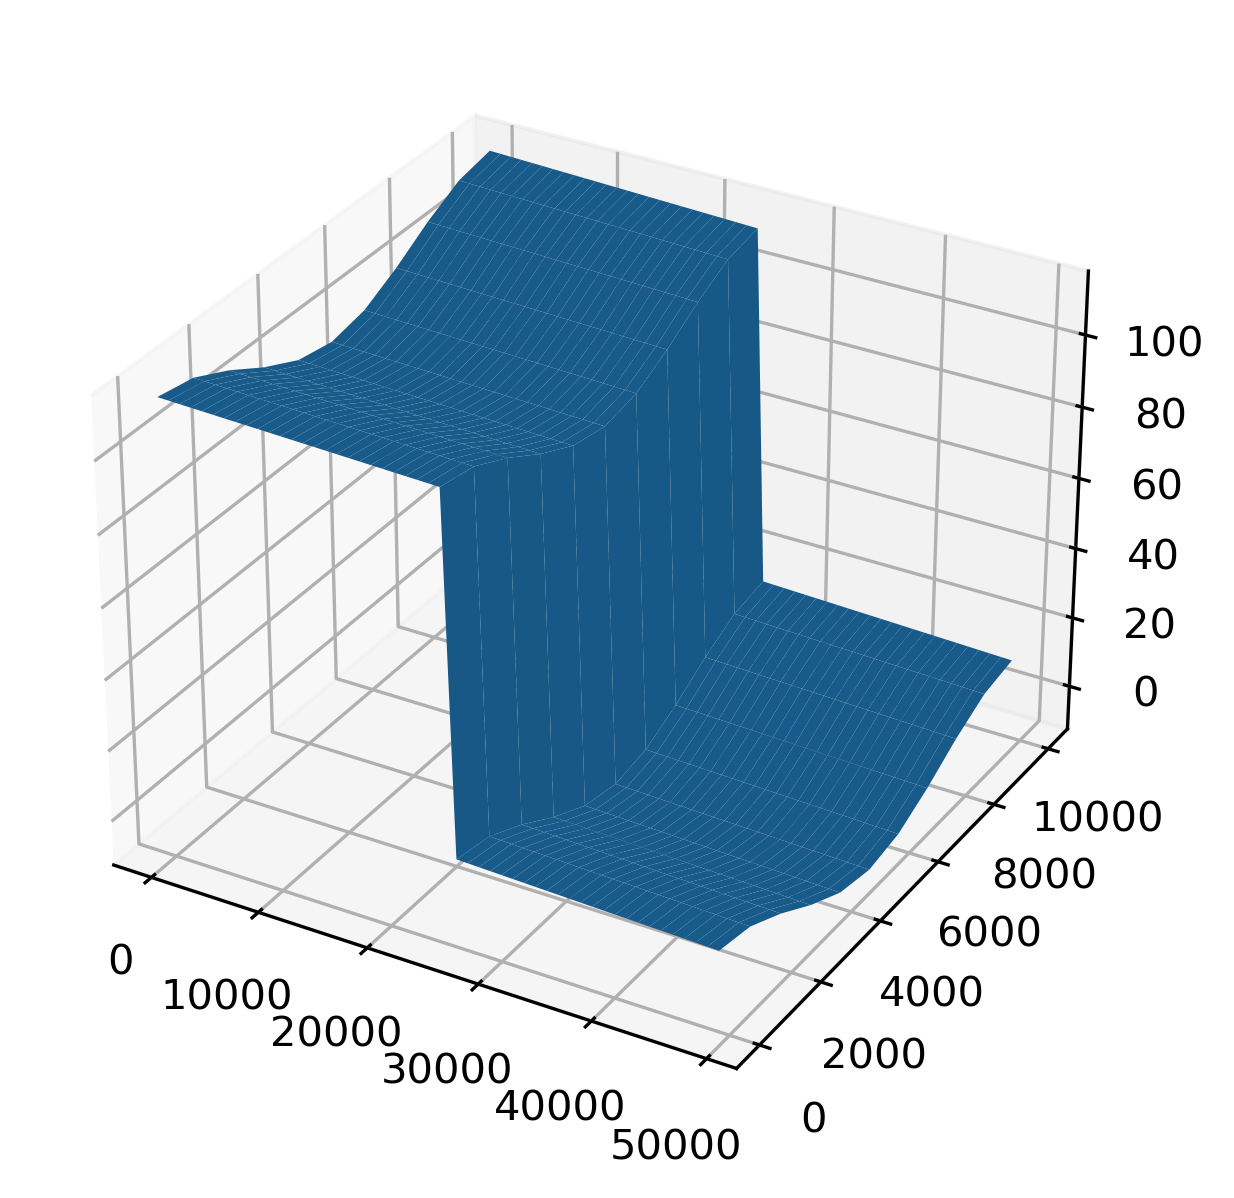

In [41]:
# Plot the starting topography
ax = plt.axes(projection="3d")
_ = ax.plot_surface(
    model.grid.x_of_node.reshape((nrows, ncols)),
    model.grid.y_of_node.reshape((nrows, ncols)),
    model.elev.reshape((nrows, ncols)),
)

In [42]:
model.run()

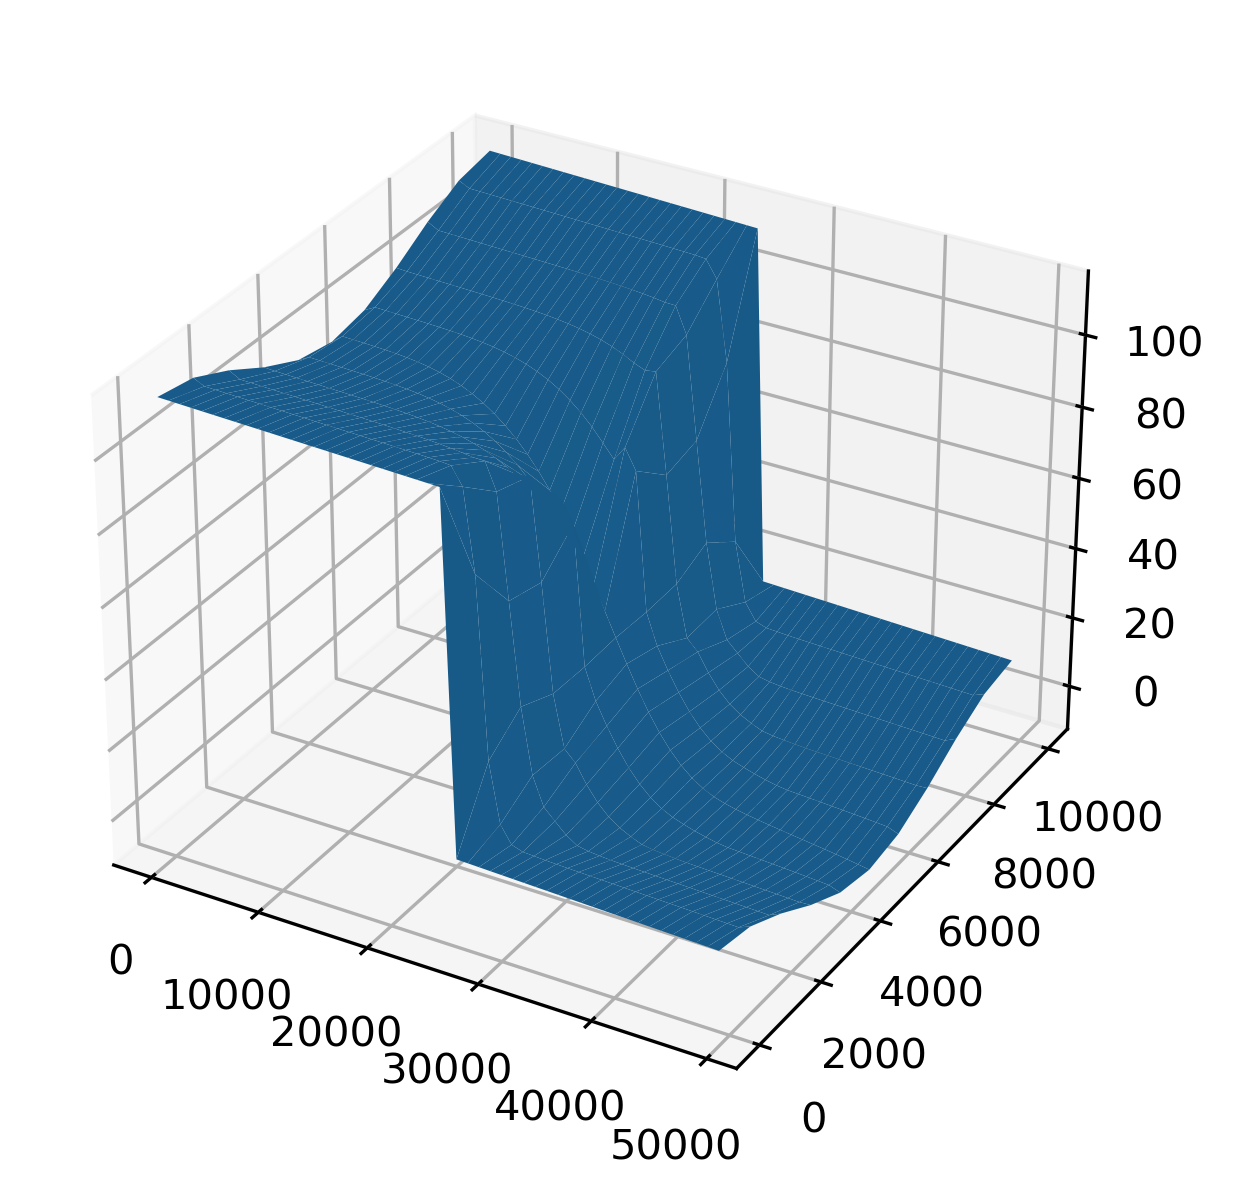

In [43]:
# Plot the final topography
ax = plt.axes(projection="3d")
_ = ax.plot_surface(
    model.grid.x_of_node.reshape((nrows, ncols)),
    model.grid.y_of_node.reshape((nrows, ncols)),
    model.elev.reshape((nrows, ncols)),
)

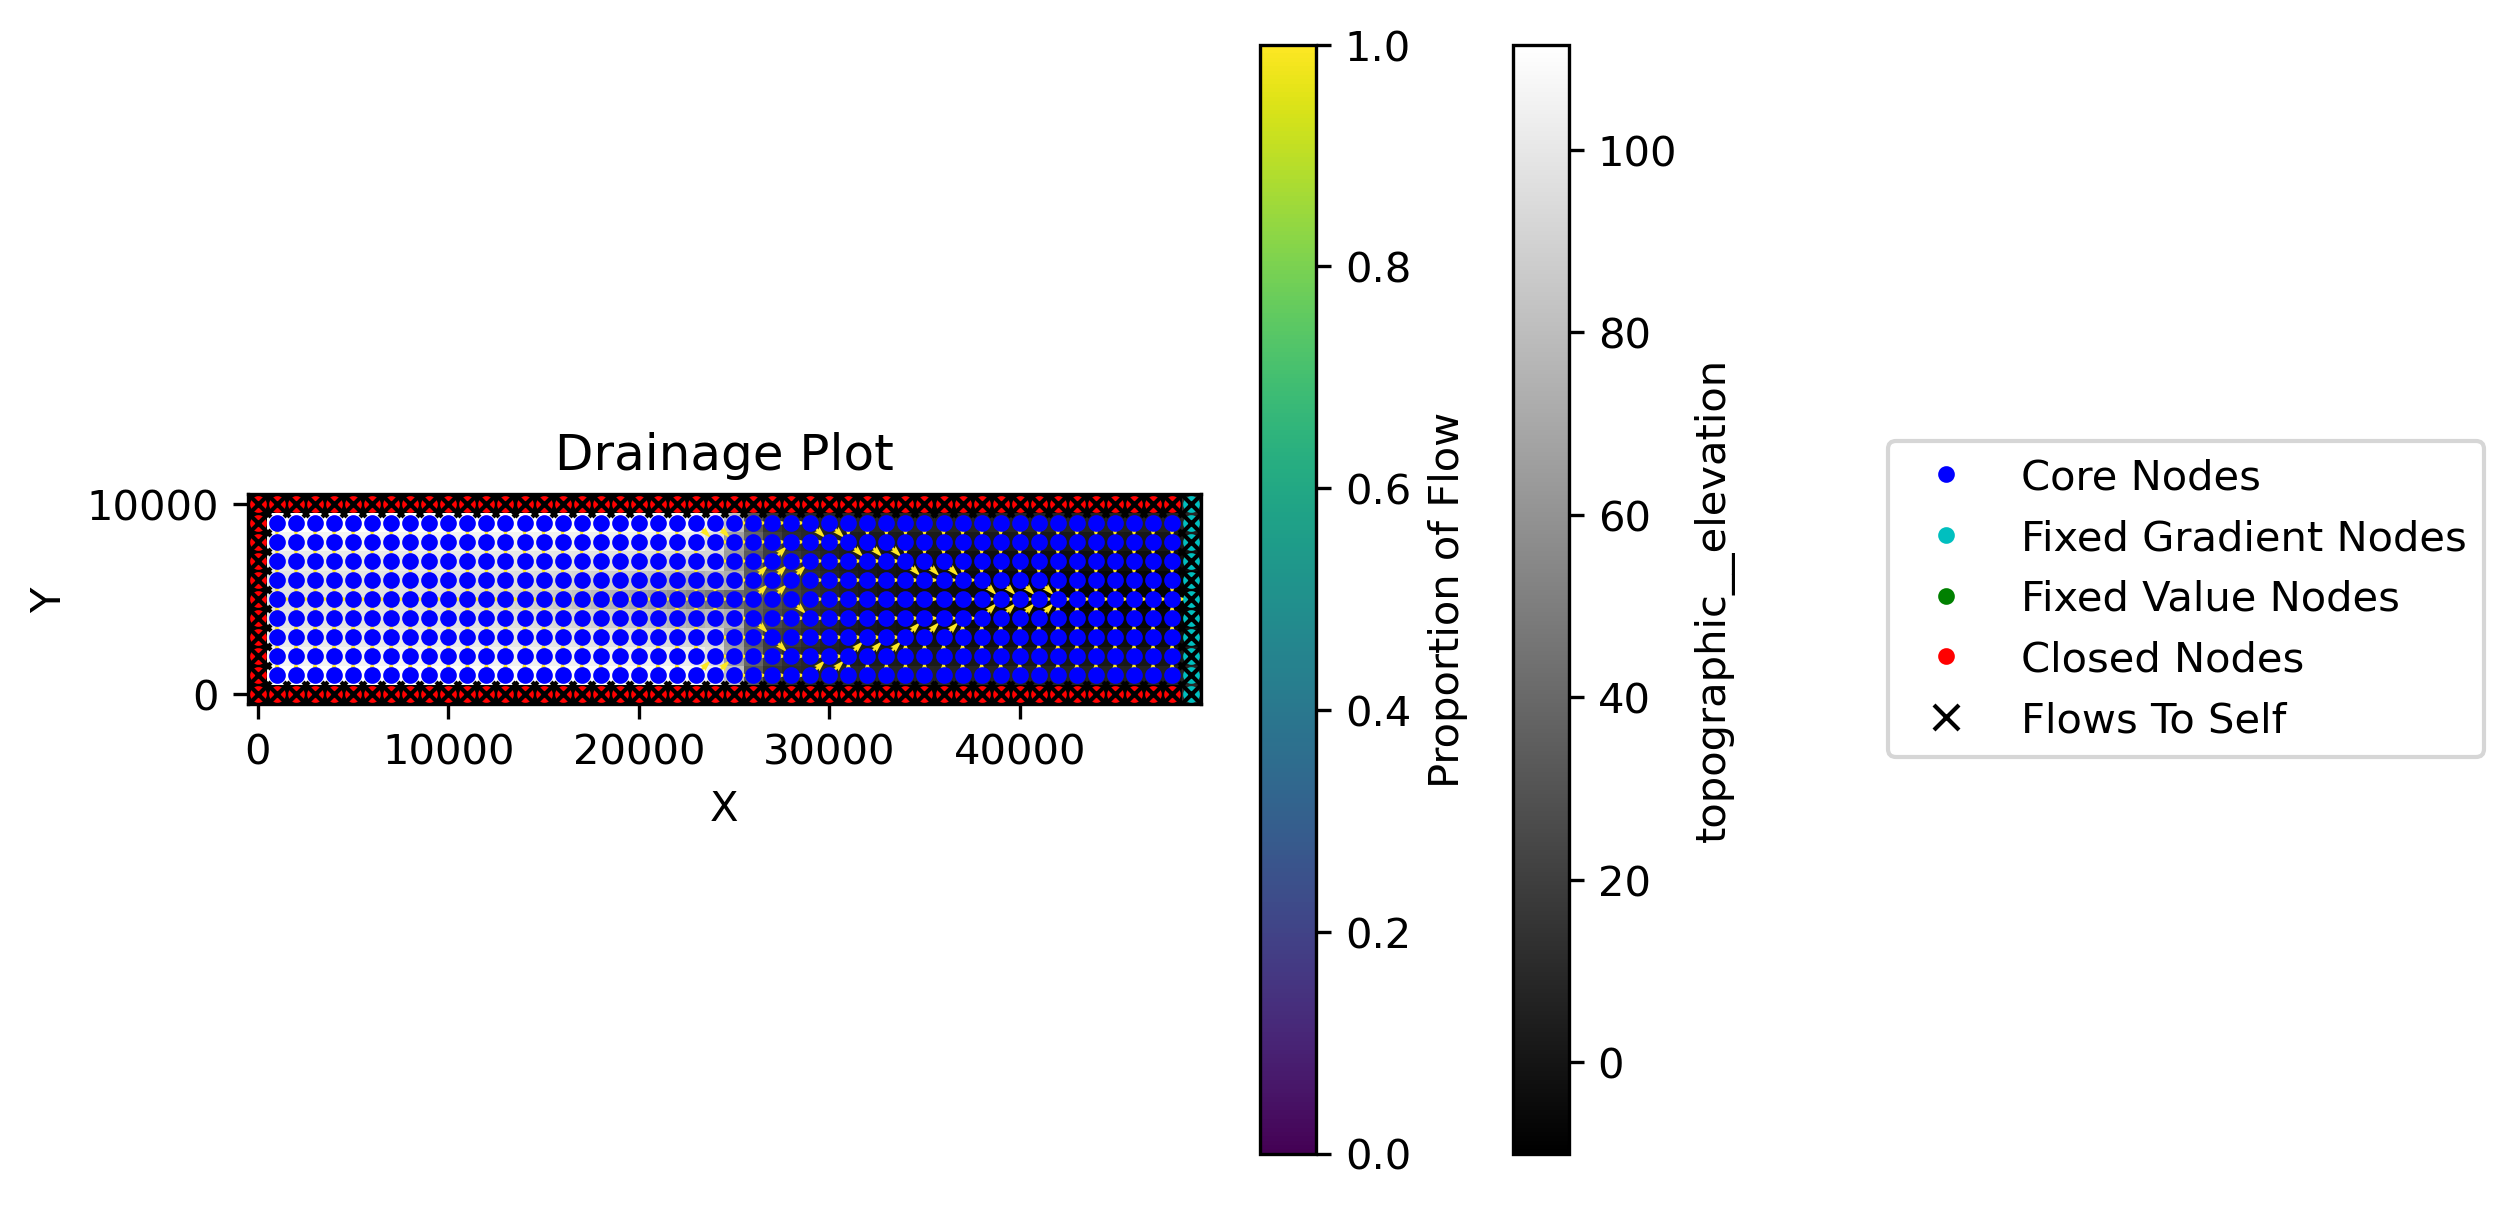

In [44]:
# Plot the final drainage pattern
plt.axes()
drainage_plot(model.grid)

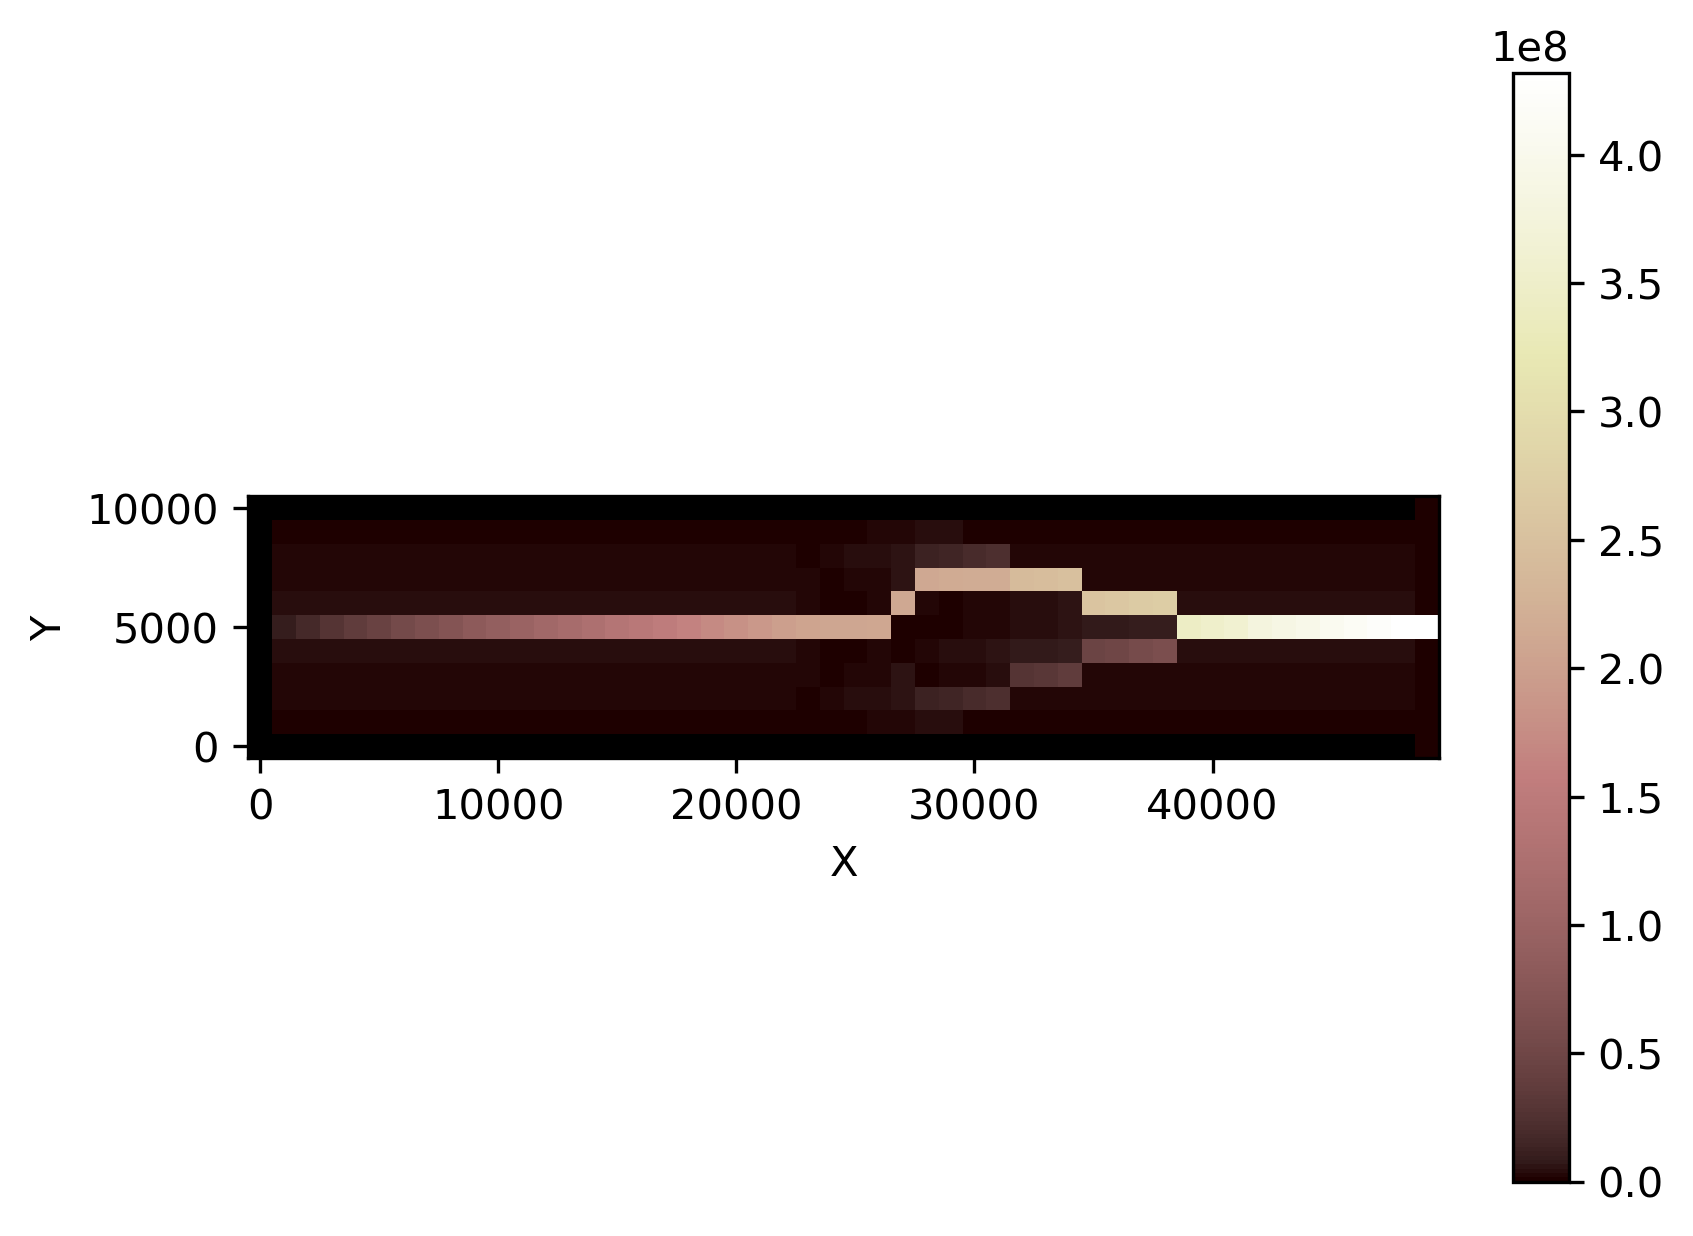

In [45]:
# Show a plan-view of drainage area
imshow_grid(model.grid, "drainage_area")

Note that a fan-like area of deposition forms at the base of the step. The flow will remain stable and fixed in the central part of the upper valley, but varies over time across the fan, as aggradation modifies the topography and leads to avulsion-like behavior.

## Concluding remarks

The `GravelRiverTransporter` component simulates a grid-based network of equilibrium-width, gravel-bed rivers in which gravel can be lost to abrasion downstream. The component is consistent with analytical solutions. One limitation of the examples shown here is that valley width is effectively uniform and equal to grid-cell width. Another limitation is that the component makes no attempt to evaluate whether the model's state variables are always consistent with the assumptions used to derive the underlying theory. For example, it is theoretically possible to have the implied channel width be so narrow that the wide-channel assumption no longer holds; similarly, it is possible to have an implied valley width larger than a single grid cell. It is also theoretically possible that the implied flow speed could become supercritical, which would be unrealistic. The user is cautioned to be aware of these limitations!

As of this writing, the only fully implemented solver is a simple explicit, forward-Euler method. A matrix-based implicit solver is under construction but not fully operational. An explicit Runge-Kutta method would also be worth trying, as would an adaptive time-stepper.

## References and further reading

Attal, M., & Lavé, J. (2006). Changes of bedload characteristics along the Marsyandi River (central Nepal): Implications for understanding hillslope sediment supply, sediment load evolution along fluvial networks, and denudation in active orogenic belts. Geol. Soc. Am. Spec. Pap, 398, 143-171.

Attal, M., & Lavé, J. (2009). Pebble abrasion during fluvial transport: Experimental results and implications for the evolution of the sediment load along rivers. Journal of Geophysical Research: Earth Surface, 114(F4).

Grant, G. E. (1997). Critical flow constrains flow hydraulics in mobile‐bed streams: A new hypothesis. Water Resources Research, 33(2), 349-358.

Meyer-Peter, E., & Müller, R. (1948). Formulas for bed-load transport. In IAHSR 2nd meeting, Stockholm, appendix 2. IAHR.

Parker, G. (1978). Self-formed straight rivers with equilibrium banks and mobile bed. Part 2. The gravel river. Journal of Fluid mechanics, 89(1), 127-146.

Phillips, C. B., & Jerolmack, D. J. (2016). Self-organization of river channels as a critical filter on climate signals. Science, 352(6286), 694-697.

Wickert, A. D., & Schildgen, T. F. (2019). Long-profile evolution of transport-limited gravel-bed rivers. Earth Surface Dynamics, 7(1), 17-43.

Willgoose, G., Bras, R. L., & Rodriguez‐Iturbe, I. (1991). A physical explanation of an observed link area‐slope relationship. Water Resources Research, 27(7), 1697-1702.

Willgoose, G. (1994). A physical explanation for an observed area‐slope‐elevation relationship for catchments with declining relief. Water Resources Research, 30(2), 151-159.

Wong, M., & Parker, G. (2006). Reanalysis and correction of bed-load relation of Meyer-Peter and Müller using their own database. Journal of Hydraulic Engineering, 132(11), 1159-1168.